# Movie Lens

## Neural Net with genre, title & tag features

#### Load and preprocess the dataset

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Embedding
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

2023-07-15 04:15:24.776578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 04:15:24.842890: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Step 1: Load and preprocess the MovieLens dataset
movies = pd.read_csv("../data/ml-latest-small/movies.csv")
movies['genres'] = movies['genres'].str.split('|')
print(movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [3]:
# Load the ratings dataset
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
print(f"There are: {ratings['userId'].nunique()} unqiue users")
print(f"There are: {ratings['movieId'].nunique()} unqiue films in the ratings dataframe")
print(f"There are: {movies['movieId'].nunique()} unqiue films in the movies dataframe")

There are: 610 unqiue users
There are: 9724 unqiue films in the ratings dataframe
There are: 9742 unqiue films in the movies dataframe


In [5]:
# Load the tags dataset
tags = pd.read_csv('../data/ml-latest/tags.csv')
print(tags.shape)
tags = tags.dropna()
tags.head()

(1108997, 4)


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


In [6]:
tags.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [7]:
tags_agg = tags.groupby('movieId')['tag'].agg(list)
tags_agg

movieId
1         [animated, buddy movie, Cartoon, cgi, comedy, ...
2         [fantasy, adapted from:book, animals, bad cgi,...
3         [moldy, old, Ann Margaret, Burgess Meredith, D...
4         [characters, girl movie, characters, chick fli...
5         [steve martin, steve martin, pregnancy, remake...
                                ...                        
193761    [concert, hostage, kidnapping, opera singer, r...
193811                          [doppelganger, Julie Delpy]
193837           [aliens, anime, cat, space marines, virus]
193864    [Alfredo Landa, anticonception, comic, family,...
193868    [black and white, comedy, friendship, fun, mar...
Name: tag, Length: 45981, dtype: object

In [8]:
movies_tag_df = pd.merge(movies, tags_agg, how='inner', on='movieId')
print(movies_tag_df.shape)
movies_tag_df.head()

(9569, 4)


,movieId,title,genres,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[fantasy, adapted from:book, animals, bad cgi,..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[moldy, old, Ann Margaret, Burgess Meredith, D..."
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","[characters, girl movie, characters, chick fli..."
4,5,Father of the Bride Part II (1995),[Comedy],"[steve martin, steve martin, pregnancy, remake..."


In [9]:
longest_tag = max(movies_tag_df['tag'], key=len)
len(longest_tag)

9478

In [10]:
#reduce number of tags to a reasonable number
no_of_tags = 100
movies_tag_df['tag'] = movies_tag_df['tag'].apply(lambda x: x[:no_of_tags] if len(x) > no_of_tags else x)
longest_tag = max(movies_tag_df['tag'], key=len)
len(longest_tag)

100

In [11]:
movielens_df = pd.merge(ratings, movies_tag_df, how='inner', on='movieId')
print(movielens_df.shape)
movielens_df.head()

(100639, 7)


,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
1,5,1,4.0,847434962,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
2,7,1,4.5,1106635946,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
3,15,1,2.5,1510577970,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
4,17,1,4.5,1305696483,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."


In [13]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(movielens_df, test_size=0.2, random_state=42)

# Determine the maximum values of userId and movieId for embedding layer sizes
max_user_id = movielens_df['userId'].max()
max_movie_id = movielens_df['movieId'].max()

# Normalize the ratings between 0 and 1
max_rating = movielens_df['rating'].max()
min_rating = movielens_df['rating'].min()
train_data['rating'] = (train_data['rating'] - min_rating) / (max_rating - min_rating)
test_data['rating'] = (test_data['rating'] - min_rating) / (max_rating - min_rating)

# Prepare the input data for the neural network
train_user_ids = train_data['userId'].values
train_movie_ids = train_data['movieId'].values
train_movie_titles = train_data['title'].values
train_genres = train_data['genres'].values
train_tags = train_data['tag'].values
train_ratings = train_data['rating'].values

test_user_ids = test_data['userId'].values
test_movie_ids = test_data['movieId'].values
test_movie_titles = test_data['title'].values
test_genres = test_data['genres'].values
test_tags = test_data['tag'].values
test_ratings = test_data['rating'].values

In [14]:
print(train_user_ids.shape)
print(train_movie_ids.shape)
print(train_movie_titles.shape)
print(train_tags.shape)
print(train_genres.shape)
print(train_ratings.shape)

(80511,)
(80511,)
(80511,)
(80511,)
(80511,)
(80511,)


In [15]:
# Find the longest movie title in the dataset
longest_movie = max(movielens_df['title'], key=len)
len(set(longest_movie.split()))

22

In [24]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad title sequences to have consistent lengths
max_title_length = 30

# Convert movie titles to sequences of word indices, convert to padded array for input to model
#Find the length of the title vocab size
all_of_the_movie_titles = movielens_df['title'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_of_the_movie_titles)
all_of_the_title_sequences = tokenizer.texts_to_sequences(all_of_the_movie_titles)
all_of_the_title_sequences = pad_sequences(all_of_the_title_sequences, maxlen=max_title_length)
title_vocab_size = len(tokenizer.word_index)+1
print(title_vocab_size)

# Convert train data movie titles to sequences of word indices, convert to padded array for input to model
tokenizer.fit_on_texts(train_movie_titles)
train_title_sequences = tokenizer.texts_to_sequences(train_movie_titles)
train_title_sequences = pad_sequences(train_title_sequences, maxlen=max_title_length)
print(train_title_sequences.shape)

# Convert test data movie titles to sequences of word indices, convert to padded array for input to model
tokenizer.fit_on_texts(test_movie_titles)
test_title_sequences = tokenizer.texts_to_sequences(test_movie_titles)
test_title_sequences = pad_sequences(test_title_sequences, maxlen=max_title_length)
print(test_title_sequences.shape)

9361
(80511, 30)
(20128, 30)


In [21]:
# Find the movie with the most genres
longest_genre = max(movielens_df['genres'], key=len)
print(longest_genre)
print(len(longest_genre))

['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Film-Noir', 'Horror', 'Mystery', 'Thriller', 'Western']
10


In [28]:
# Pad title sequences to have consistent lengths
max_genres_length = 15

# Convert movie titles to sequences of word indices, convert to padded array for input to model
#Find the length of the title vocab size
all_of_the_genres = movielens_df['genres'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_of_the_genres)
all_of_the_genres_sequences = tokenizer.texts_to_sequences(all_of_the_genres)
all_of_the_genres_sequences = pad_sequences(all_of_the_genres_sequences, maxlen=max_genres_length)
genre_vocab_size = len(tokenizer.word_index)+1
print(genre_vocab_size)

# Convert train data movie titles to sequences of word indices, convert to padded array for input to model
tokenizer.fit_on_texts(train_genres)
train_genres_sequences = tokenizer.texts_to_sequences(train_genres)
train_genres_sequences = pad_sequences(train_genres_sequences, maxlen=max_genres_length)
print(train_genres_sequences.shape)

# Convert test data movie titles to sequences of word indices, convert to padded array for input to model
tokenizer.fit_on_texts(test_genres)
test_genres_sequences = tokenizer.texts_to_sequences(test_genres)
test_genres_sequences = pad_sequences(test_genres_sequences, maxlen=max_genres_length)
print(test_genres_sequences.shape)

21
(80511, 15)
(20128, 15)


In [29]:
# Find the longest tags in the dataset
longest_tag = max(movielens_df['tag'], key=len)
print(len(longest_tag))

distinct_words = {word for tags in longest_tag for word in tags.split()}
len(distinct_words)
# distinct_words

# longest_tag_words = []
# for tags in longest_tag:
#     for words in tags.split():
#         longest_tag_words.append(words)
# distinct_words = set(longest_tag_words)

100


37

In [30]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad tag sequences to have consistent lengths
max_tag_length = 100

# Convert movie titles to sequences of word indices, convert to padded array for input to model
#Find the length of the tag vocab size
all_of_the_tags = movielens_df['tag'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_of_the_tags)
all_of_the_tag_sequences = tokenizer.texts_to_sequences(all_of_the_tags)
all_of_the_tag_sequences = pad_sequences(all_of_the_tag_sequences, maxlen=max_tag_length)
tag_vocab_size = len(tokenizer.word_index)+1
print(tag_vocab_size)

# Convert train data movie tags to sequences of word indices, convert to padded array for input to model
tokenizer.fit_on_texts(train_tags)
train_tag_sequences = tokenizer.texts_to_sequences(train_tags)
train_tag_sequences = pad_sequences(train_tag_sequences, maxlen=max_tag_length)
print(train_tag_sequences.shape)

# Convert test data movie tags to sequences of word indices, convert to padded array for input to model
tokenizer.fit_on_texts(test_tags)
test_tag_sequences = tokenizer.texts_to_sequences(test_tags)
test_tag_sequences = pad_sequences(test_tag_sequences, maxlen=max_tag_length)
print(test_tag_sequences.shape)

40236
(80511, 100)
(20128, 100)


#### Define the neural network model

In [105]:
# Define the embedding sizes for userId and movieId
embedding_size = 50

# Create the input layers
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')
title_input = Input(shape=(max_title_length,), name='title_input')
genre_input = Input(shape=(max_genres_length,), name='genre_input')
tag_input = Input(shape=(max_tag_length,), name='tag_input')

# Create embedding layers for all inputs
user_embedding = Embedding(max_user_id + 1, embedding_size)(user_input)
user_flat = Flatten()(user_embedding)
movie_embedding = Embedding(max_movie_id + 1, embedding_size)(movie_input)
movie_flat = Flatten()(movie_embedding)
title_embedding = Embedding(title_vocab_size + 1, embedding_size)(title_input)
title_flat = Flatten()(title_embedding)
genre_embedding = Embedding(genre_vocab_size + 1, embedding_size)(genre_input)
genre_flat = Flatten()(genre_embedding)
tag_embedding = Embedding(tag_vocab_size + 1, embedding_size)(tag_input)
tag_flat = Flatten()(tag_embedding)

# Merge the embeddings with genre input
merge = Concatenate()([user_flat, movie_flat, title_flat, genre_flat, genre_input])

# Add fully connected layers for prediction
dense = Dense(128, activation='relu')(merge)
dense = Dense(64, activation='relu')(dense)  # Additional dense layer
dense = Dense(32, activation='relu')(dense)  # Additional dense layer
output = Dense(1)(dense)

#create and compile the model
model5 = Model(inputs=[user_input, movie_input, title_input, genre_input, tag_input], outputs=output)
model5.compile(loss='mse', optimizer='adam')

In [ ]:
#Train the Model
# CHANGE MODEL NAME!!!
epochs = 200
batch_size = 256

model5.fit([train_user_ids, train_movie_ids, train_title_sequences, train_genres_sequences, train_tag_sequences], train_ratings, batch_size=batch_size, epochs=epochs)

Epoch 1/200
315/315 [==============================] - 11s 34ms/step - loss: 0.0358
Epoch 2/200
315/315 [==============================] - 11s 34ms/step - loss: 0.0338
Epoch 3/200
315/315 [==============================] - 10s 33ms/step - loss: 0.0322
Epoch 4/200
315/315 [==============================] - 11s 33ms/step - loss: 0.0309
Epoch 5/200
315/315 [==============================] - 11s 35ms/step - loss: 0.0298
Epoch 6/200
315/315 [==============================] - 11s 35ms/step - loss: 0.0287
Epoch 7/200
315/315 [==============================] - 11s 34ms/step - loss: 0.0276
Epoch 8/200
315/315 [==============================] - 11s 35ms/step - loss: 0.0264
Epoch 9/200
315/315 [==============================] - 11s 34ms/step - loss: 0.0253
Epoch 10/200
315/315 [==============================] - 11s 35ms/step - loss: 0.0240
Epoch 11/200
315/315 [==============================] - 11s 35ms/step - loss: 0.0228
Epoch 12/200
315/315 [==============================] - 11s 35ms/step - lo

#### Results

In [59]:
# test_ratings = test_ratings * (max_rating - min_rating) + min_rating
test_ratings

array([4.5, 4.5, 3. , ..., 4. , 3. , 4. ])

In [104]:
predictions5 = model5.predict([test_user_ids, 
                              test_movie_ids, 
                              test_title_sequences,
                              test_genres_sequences, 
                              test_tag_sequences])
predictions5 = predictions5.flatten()


predictions5 = predictions5 * (max_rating - min_rating) + min_rating

print("the highest rating the model predicted is:", np.max(predictions5))
# predictions = np.clip(predictions, a_min=None, a_max=5.0)

rmse = np.sqrt(mean_squared_error(test_ratings, predictions5))
print('RMSE:', rmse)

629/629 [==============================] - 1s 1ms/step
the highest rating the model predicted is: 6.2232637
RMSE: 0.9833275446212841


In [61]:
predictions4

array([4.1560497, 3.949033 , 3.8675003, ..., 4.0265493, 2.5588243,
       4.023562 ], dtype=float32)

In [62]:
movielens_df

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
1,5,1,4.0,847434962,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
2,7,1,4.5,1106635946,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
3,15,1,2.5,1510577970,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
4,17,1,4.5,1305696483,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
...,...,...,...,...,...,...,...
100634,610,160341,2.5,1479545749,Bloodmoon (1997),"[Action, Thriller]","[kick boxing, martial arts]"
100635,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),"[Action, Crime, Drama]","[okinawa, Japan, Japanese, Okinawa, organized ..."
100636,610,160836,3.0,1493844794,Hazard (2005),"[Action, Drama, Thriller]",[drama]
100637,610,163937,3.5,1493848789,Blair Witch (2016),"[Horror, Thriller]","[sequel, blair witch, campfire, camping, flash..."


#### Time to Use Model for Results

In [63]:
movies_tag_df

,movieId,title,genres,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[fantasy, adapted from:book, animals, bad cgi,..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[moldy, old, Ann Margaret, Burgess Meredith, D..."
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","[characters, girl movie, characters, chick fli..."
4,5,Father of the Bride Part II (1995),[Comedy],"[steve martin, steve martin, pregnancy, remake..."
...,...,...,...,...
9564,189713,BlacKkKlansman (2018),"[Comedy, Crime, Drama]","[forced, naive, reviewed, A Spike Lee Joint, a..."
9565,190183,The Darkest Minds (2018),"[Sci-Fi, Thriller]","[Adolescents, Based on book, Mind power, Super..."
9566,190209,Jeff Ross Roasts the Border (2017),[Comedy],"[border, comedy, immigration, Jeff Ross, Roast]"
9567,190213,John From (2015),[Drama],"[adolescence, coming of age, dreams, fantasy]"


In [73]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert movie titles to sequences of word indices, convert to padded array for input to model
#Find the length of the title vocab size
all_of_the_movie_titles = movies_tag_df['title'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_of_the_movie_titles)
all_of_the_title_sequences = tokenizer.texts_to_sequences(all_of_the_movie_titles)
all_of_the_title_sequences = pad_sequences(all_of_the_title_sequences, maxlen=max_title_length)
title_vocab_size = len(tokenizer.word_index)+1
print(title_vocab_size)

# Convert movie titles to sequences of word indices, convert to padded array for input to model
#Find the length of the title vocab size
all_of_the_genres = movies_tag_df['genres'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_of_the_genres)
all_of_the_genres_sequences = tokenizer.texts_to_sequences(all_of_the_genres)
all_of_the_genres_sequences = pad_sequences(all_of_the_genres_sequences, maxlen=max_genres_length)
genres_vocab_size = len(tokenizer.word_index)+1
print(genres_vocab_size)

# Convert tags to sequences of word indices, convert to padded array for input to model
#Find the length of the tag vocab size
all_of_the_tags = movies_tag_df['tag'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_of_the_tags)
all_of_the_tag_sequences = tokenizer.texts_to_sequences(all_of_the_tags)
all_of_the_tag_sequences = pad_sequences(all_of_the_tag_sequences, maxlen=max_tag_length)
tag_vocab_size = len(tokenizer.word_index)+1
print(tag_vocab_size)


9377
21
40286


In [65]:
print(all_of_the_title_sequences.shape)
print(all_of_the_genres_sequences.shape)
print(all_of_the_tag_sequences.shape)

(9569, 30)
(9569, 15)
(9569, 100)


In [66]:
len(np.array(movie_ids))

9569

In [72]:
all_of_the_tag_sequences

array([[  333,   644,   717, ...,   133,    25,    43],
       [   14,    69,   373, ...,    25,    28,    27],
       [    0,     0,     0, ...,    36,     3,    48],
       ...,
       [    0,     0,     0, ...,  2017, 40283, 14370],
       [    0,     0,     0, ...,    35,   438,    14],
       [    0,     0,     0, ...,     1, 40284, 40285]], dtype=int32)

In [74]:
all_of_the_genres_sequences

array([[ 0,  0,  0, ..., 11,  2, 10],
       [ 0,  0,  0, ...,  6, 11, 10],
       [ 0,  0,  0, ...,  0,  2,  5],
       ...,
       [ 0,  0,  0, ...,  0,  0,  2],
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ..., 12,  2,  8]], dtype=int32)

In [75]:
#get all the values of the movie Ids
movie_ids = movies_tag_df['movieId'].values

# Choose the user for whom you want to make recommendations
test_user = 576

# Get predictions for all movies for the selected user
user_predictions = model4.predict([np.array([test_user] * len(movie_ids)), 
                                   np.array(movie_ids), 
                                   all_of_the_title_sequences, 
                                   all_of_the_genres_sequences, 
                                   all_of_the_tag_sequences])

# Unnormalize the ratings
min_rating = 0.5  # Replace with the actual minimum rating in the dataset
max_rating = 5.0  # Replace with the actual maximum rating in the dataset
user_predictions = user_predictions * (max_rating - min_rating) + min_rating

# user_predictions = np.clip(user_predictions, a_min=None, a_max=5.0)

# Sort the predictions in descending order and get the indices of the top 3 movies
top_movie_indices = user_predictions.argsort(axis=0)[::-1][:3]

# Retrieve the movie IDs of the top 3 movies
print("Top 3 Recommended Films for User", test_user)
for index in top_movie_indices:
    movie_title = movies.loc[index, 'title'].values
    rating = user_predictions[index]
    print("Movie:", movie_title[0], "| Predicted Rating:", rating[0][0])

300/300 [==============================] - 0s 1ms/step
Top 3 Recommended Films for User 576
Movie: Ted (2012) | Predicted Rating: 4.6296144
Movie: Delirium (2014) | Predicted Rating: 4.5864086
Movie: Zulu (2013) | Predicted Rating: 4.5494175


In [76]:
movielens_df

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
1,5,1,4.0,847434962,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
2,7,1,4.5,1106635946,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
3,15,1,2.5,1510577970,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
4,17,1,4.5,1305696483,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
...,...,...,...,...,...,...,...
100634,610,160341,2.5,1479545749,Bloodmoon (1997),"[Action, Thriller]","[kick boxing, martial arts]"
100635,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),"[Action, Crime, Drama]","[okinawa, Japan, Japanese, Okinawa, organized ..."
100636,610,160836,3.0,1493844794,Hazard (2005),"[Action, Drama, Thriller]",[drama]
100637,610,163937,3.5,1493848789,Blair Witch (2016),"[Horror, Thriller]","[sequel, blair witch, campfire, camping, flash..."


In [95]:
# Choose the user for whom you want to make recommendations
test_user = 576

#create user_ratings dataframe
user_ratings = movielens_df[movielens_df['userId'] == test_user][['userId', 'movieId','title', 'rating']].sort_values(by='movieId').reset_index(drop=True)
user_films_viewed = user_ratings['movieId'].values

#filter the title sequences to only include the movies that the user has watched
user_movie_titles = all_of_the_title_sequences[user_films_viewed]

#filter the genre sequences to only include the movies that the user has watched
user_movie_genres = all_of_the_genres_sequences[user_films_viewed]

#filter the tag sequences to only include the movies that the user has watched
user_movie_tags = all_of_the_tag_sequences[user_films_viewed]

# Create an array of the user ID to match the shape of user_films_viewed
user_id_array = np.array([test_user] * len(user_films_viewed))

# Get the model predictions for the user and movie IDs
user_predictions = model4.predict([user_id_array, user_films_viewed, user_movie_titles, user_movie_genres, user_movie_tags])
user_predictions = user_predictions * (max_rating - min_rating) + min_rating
# user_predictions = np.clip(user_predictions, a_min=None, a_max=5.0)

#add a column for predicted rating to the data frame
user_ratings['predicted_rating'] = user_predictions
user_ratings.sort_values(by='rating',ascending=False)

1/1 [==============================] - 0s 16ms/step


,userId,movieId,title,rating,predicted_rating
14,576,2289,"Player, The (1992)",5.0,3.117771
13,576,1479,"Saint, The (1997)",5.0,3.196988
19,576,3082,"World Is Not Enough, The (1999)",4.5,3.411646
18,576,2826,"13th Warrior, The (1999)",4.5,2.521416
15,576,2580,Go (1999),4.5,3.806246
9,576,1321,"American Werewolf in London, An (1981)",4.0,3.289198
17,576,2723,Mystery Men (1999),4.0,2.482383
10,576,1345,Carrie (1976),4.0,2.496597
6,576,1223,"Grand Day Out with Wallace and Gromit, A (1989)",4.0,3.449208
0,576,29,"City of Lost Children, The (Cité des enfants p...",3.5,3.059948


## Neural Net with genre, title & tag features

#### Load and preprocess the dataset

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Embedding
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

2023-07-14 23:18:58.153150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 23:18:58.191367: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Step 1: Load and preprocess the MovieLens dataset
movies = pd.read_csv("../data/ml-latest-small/movies.csv")
movies['genres'] = movies['genres'].str.split('|')
print(movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [3]:
# Load the ratings dataset
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
print(f"There are: {ratings['userId'].nunique()} unqiue users")
print(f"There are: {ratings['movieId'].nunique()} unqiue films in the ratings dataframe")
print(f"There are: {movies['movieId'].nunique()} unqiue films in the movies dataframe")

There are: 610 unqiue users
There are: 9724 unqiue films in the ratings dataframe
There are: 9742 unqiue films in the movies dataframe


In [5]:
# Load the tags dataset
tags = pd.read_csv('../data/ml-latest/tags.csv')
print(tags.shape)
tags = tags.dropna()
tags.head()

(1108997, 4)


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


In [6]:
tags.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [7]:
tags_agg = tags.groupby('movieId')['tag'].agg(list)
tags_agg

movieId
1         [animated, buddy movie, Cartoon, cgi, comedy, ...
2         [fantasy, adapted from:book, animals, bad cgi,...
3         [moldy, old, Ann Margaret, Burgess Meredith, D...
4         [characters, girl movie, characters, chick fli...
5         [steve martin, steve martin, pregnancy, remake...
                                ...                        
193761    [concert, hostage, kidnapping, opera singer, r...
193811                          [doppelganger, Julie Delpy]
193837           [aliens, anime, cat, space marines, virus]
193864    [Alfredo Landa, anticonception, comic, family,...
193868    [black and white, comedy, friendship, fun, mar...
Name: tag, Length: 45981, dtype: object

In [31]:
movies_tag_df = pd.merge(movies, tags_agg, how='inner', on='movieId')
print(movies_tag_df.shape)
movies_tag_df.head()

(9569, 4)


,movieId,title,genres,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[fantasy, adapted from:book, animals, bad cgi,..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[moldy, old, Ann Margaret, Burgess Meredith, D..."
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","[characters, girl movie, characters, chick fli..."
4,5,Father of the Bride Part II (1995),[Comedy],"[steve martin, steve martin, pregnancy, remake..."


In [32]:
longest_tag = max(movies_tag_df['tag'], key=len)
len(longest_tag)

9478

In [38]:
#reduce number of tags to a reasonable number
no_of_tags = 100
movies_tag_df['tag'] = movies_tag_df['tag'].apply(lambda x: x[:no_of_tags] if len(x) > no_of_tags else x)
longest_tag = max(movies_tag_df['tag'], key=len)
len(longest_tag)

100

In [40]:
movielens_df = pd.merge(ratings, movies_tag_df, how='inner', on='movieId')
print(movielens_df.shape)
movielens_df.head()

(100639, 7)


,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
1,5,1,4.0,847434962,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
2,7,1,4.5,1106635946,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
3,15,1,2.5,1510577970,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
4,17,1,4.5,1305696483,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."


In [41]:
movielens_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
tag          0
dtype: int64

In [42]:
# Extract the genre information from the ratings dataframe
genre_lists = movielens_df['genres'].tolist()

# Perform one-hot encoding on the genre lists
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(genre_lists)

# Retrieve the list of genre classes
genre_classes = mlb.classes_

# Create a new dataframe with the one-hot encoded genre features
genre_df = pd.DataFrame(genre_features, columns=genre_classes)
genre_df

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100634,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
100635,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
100636,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
100637,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [43]:
movielens_df_with_genre = pd.concat([movielens_df, genre_df], axis=1)
movielens_df_with_genre

,userId,movieId,rating,timestamp,title,genres,tag,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ...",0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,5,1,4.0,847434962,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ...",0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,4.5,1106635946,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ...",0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,15,1,2.5,1510577970,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ...",0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,17,1,4.5,1305696483,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ...",0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100634,610,160341,2.5,1479545749,Bloodmoon (1997),"[Action, Thriller]","[kick boxing, martial arts]",0,1,0,...,0,0,0,0,0,0,0,1,0,0
100635,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),"[Action, Crime, Drama]","[okinawa, Japan, Japanese, Okinawa, organized ...",0,1,0,...,0,0,0,0,0,0,0,0,0,0
100636,610,160836,3.0,1493844794,Hazard (2005),"[Action, Drama, Thriller]",[drama],0,1,0,...,0,0,0,0,0,0,0,1,0,0
100637,610,163937,3.5,1493848789,Blair Witch (2016),"[Horror, Thriller]","[sequel, blair witch, campfire, camping, flash...",0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [90]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(movielens_df_with_genre, test_size=0.2, random_state=42)

# Determine the maximum values of userId and movieId for embedding layer sizes
max_user_id = movielens_df_with_genre['userId'].max()
max_movie_id = movielens_df_with_genre['movieId'].max()

# Normalize the ratings between 0 and 1
max_rating = movielens_df_with_genre['rating'].max()
min_rating = movielens_df_with_genre['rating'].min()
train_data['rating'] = (train_data['rating'] - min_rating) / (max_rating - min_rating)
test_data['rating'] = (test_data['rating'] - min_rating) / (max_rating - min_rating)

# Prepare the input data for the neural network
train_user_ids = train_data['userId'].values
train_movie_ids = train_data['movieId'].values
train_movie_titles = train_data['title'].values
train_tags = train_data['tag'].values
train_genres = train_data.iloc[:, -20:].values
train_ratings = train_data['rating'].values

test_user_ids = test_data['userId'].values
test_movie_ids = test_data['movieId'].values
test_movie_titles = test_data['title'].values
test_tags = test_data['tag'].values
test_genres = test_data.iloc[:, -20:].values
test_ratings = test_data['rating'].values

In [45]:
print(train_user_ids.shape)
print(train_movie_ids.shape)
print(train_movie_titles.shape)
print(train_tags.shape)
print(train_genres.shape)
print(train_ratings.shape)

(80511,)
(80511,)
(80511,)
(80511,)
(80511, 20)
(80511,)


In [46]:
# Find the longest movie title in the dataset
longest_movie = max(movielens_df['title'], key=len)
len(set(longest_movie.split()))

22

In [47]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad title sequences to have consistent lengths
max_title_length = 30

# Convert movie titles to sequences of word indices, convert to padded array for input to model
#Find the length of the title vocab size
all_of_the_movie_titles = movielens_df['title'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_of_the_movie_titles)
all_of_the_title_sequences = tokenizer.texts_to_sequences(all_of_the_movie_titles)
all_of_the_title_sequences = pad_sequences(all_of_the_title_sequences, maxlen=max_title_length)
title_vocab_size = len(tokenizer.word_index)+1
print(title_vocab_size)

# Convert train data movie titles to sequences of word indices, convert to padded array for input to model
tokenizer.fit_on_texts(train_movie_titles)
train_title_sequences = tokenizer.texts_to_sequences(train_movie_titles)
train_title_sequences = pad_sequences(train_title_sequences, maxlen=max_title_length)
print(train_title_sequences.shape)

# Convert test data movie titles to sequences of word indices, convert to padded array for input to model
tokenizer.fit_on_texts(test_movie_titles)
test_title_sequences = tokenizer.texts_to_sequences(test_movie_titles)
test_title_sequences = pad_sequences(test_title_sequences, maxlen=max_title_length)
print(test_title_sequences.shape)

9361
(80511, 30)
(20128, 30)


In [48]:
# Find the longest tags in the dataset
longest_tag = max(movielens_df['tag'], key=len)
print(len(longest_tag))

distinct_words = {word for tags in longest_tag for word in tags.split()}
len(distinct_words)
# distinct_words

# longest_tag_words = []
# for tags in longest_tag:
#     for words in tags.split():
#         longest_tag_words.append(words)
# distinct_words = set(longest_tag_words)

100


37

In [49]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad tag sequences to have consistent lengths
max_tag_length = 100

# Convert movie titles to sequences of word indices, convert to padded array for input to model
#Find the length of the tag vocab size
all_of_the_tags = movielens_df['tag'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_of_the_tags)
all_of_the_tag_sequences = tokenizer.texts_to_sequences(all_of_the_tags)
all_of_the_tag_sequences = pad_sequences(all_of_the_tag_sequences, maxlen=max_tag_length)
tag_vocab_size = len(tokenizer.word_index)+1
print(tag_vocab_size)

# Convert train data movie tags to sequences of word indices, convert to padded array for input to model
tokenizer.fit_on_texts(train_tags)
train_tag_sequences = tokenizer.texts_to_sequences(train_tags)
train_tag_sequences = pad_sequences(train_tag_sequences, maxlen=max_tag_length)
print(train_tag_sequences.shape)

# Convert test data movie tags to sequences of word indices, convert to padded array for input to model
tokenizer.fit_on_texts(test_tags)
test_tag_sequences = tokenizer.texts_to_sequences(test_tags)
test_tag_sequences = pad_sequences(test_tag_sequences, maxlen=max_tag_length)
print(test_tag_sequences.shape)

40236
(80511, 100)
(20128, 100)


#### Define the neural network model

In [70]:
# Define the embedding sizes for userId and movieId
embedding_size = 50

# Create the input layers
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')
genre_input = Input(shape=(genre_df.shape[1],), name='genre_input')
title_input = Input(shape=(max_title_length,), name='title_input')
tag_input = Input(shape=(max_tag_length,), name='tag_input')

# Create embedding layers for user ID, movie ID and 
user_embedding = Embedding(max_user_id + 1, embedding_size)(user_input)
user_flat = Flatten()(user_embedding)
movie_embedding = Embedding(max_movie_id + 1, embedding_size)(movie_input)
movie_flat = Flatten()(movie_embedding)
title_embedding = Embedding(title_vocab_size + 1, embedding_size)(title_input)
title_flat = Flatten()(title_embedding)
tag_embedding = Embedding(tag_vocab_size + 1, 100)(tag_input)
tag_flat = Flatten()(tag_embedding)

# Merge the embeddings with genre input
merge = Concatenate()([user_flat, movie_flat, title_flat, tag_flat, genre_input])

# Add fully connected layers for prediction
dense = Dense(64, activation='relu')(merge)
output = Dense(1)(dense)

#create and compile the model
model4 = Model(inputs=[user_input, movie_input, title_input, tag_input, genre_input], outputs=output)
model4.compile(loss='mse', optimizer='adam')

In [95]:
#Train the Model
# CHANGE MODEL NAME!!!
epochs = 60
batch_size = 256

model4.fit([train_user_ids, train_movie_ids, train_title_sequences, train_tag_sequences, train_genres], train_ratings, batch_size=batch_size, epochs=epochs)

Epoch 1/60
315/315 [==============================] - 19s 59ms/step - loss: 0.0202
Epoch 2/60
315/315 [==============================] - 20s 64ms/step - loss: 0.0200
Epoch 3/60
315/315 [==============================] - 19s 60ms/step - loss: 0.0198
Epoch 4/60
315/315 [==============================] - 18s 59ms/step - loss: 0.0196
Epoch 5/60
315/315 [==============================] - 19s 60ms/step - loss: 0.0195
Epoch 6/60
315/315 [==============================] - 19s 61ms/step - loss: 0.0193
Epoch 7/60
315/315 [==============================] - 20s 62ms/step - loss: 0.0192
Epoch 8/60
315/315 [==============================] - 19s 61ms/step - loss: 0.0190
Epoch 9/60
315/315 [==============================] - 19s 61ms/step - loss: 0.0188
Epoch 10/60
315/315 [==============================] - 19s 61ms/step - loss: 0.0187
Epoch 11/60
315/315 [==============================] - 19s 60ms/step - loss: 0.0185
Epoch 12/60
315/315 [==============================] - 19s 59ms/step - loss: 0.0183
E

#### Results

In [91]:
test_ratings = test_ratings * (max_rating - min_rating) + min_rating
test_ratings

array([4.5, 4.5, 3. , ..., 4. , 3. , 4. ])

In [96]:
predictions4 = model4.predict([test_user_ids, 
                              test_movie_ids, 
                              test_title_sequences,
                              test_tag_sequences,
                              test_genres])
predictions4 = predictions4.flatten()


predictions4 = predictions4 * (max_rating - min_rating) + min_rating

print("the highest rating the model predicted is:", np.max(predictions4))
# predictions = np.clip(predictions, a_min=None, a_max=5.0)

rmse = np.sqrt(mean_squared_error(test_ratings, predictions4))
print('RMSE:', rmse)

629/629 [==============================] - 1s 2ms/step
the highest rating the model predicted is: 6.2513084
RMSE: 0.9749643884240132


In [88]:
predictions4

array([3.3224845, 3.9524293, 3.726695 , ..., 3.8854918, 2.1199365,
       3.1925588], dtype=float32)

In [141]:
movielens_df

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
1,5,1,4.0,847434962,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
2,7,1,4.5,1106635946,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
3,15,1,2.5,1510577970,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
4,17,1,4.5,1305696483,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
...,...,...,...,...,...,...,...
100634,610,160341,2.5,1479545749,Bloodmoon (1997),"[Action, Thriller]","[kick boxing, martial arts]"
100635,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),"[Action, Crime, Drama]","[okinawa, Japan, Japanese, Okinawa, organized ..."
100636,610,160836,3.0,1493844794,Hazard (2005),"[Action, Drama, Thriller]",[drama]
100637,610,163937,3.5,1493848789,Blair Witch (2016),"[Horror, Thriller]","[sequel, blair witch, campfire, camping, flash..."


#### Time to Use Model for Results

In [56]:
movies_tag_df

,movieId,title,genres,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[fantasy, adapted from:book, animals, bad cgi,..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[moldy, old, Ann Margaret, Burgess Meredith, D..."
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","[characters, girl movie, characters, chick fli..."
4,5,Father of the Bride Part II (1995),[Comedy],"[steve martin, steve martin, pregnancy, remake..."
...,...,...,...,...
9564,189713,BlacKkKlansman (2018),"[Comedy, Crime, Drama]","[forced, naive, reviewed, A Spike Lee Joint, a..."
9565,190183,The Darkest Minds (2018),"[Sci-Fi, Thriller]","[Adolescents, Based on book, Mind power, Super..."
9566,190209,Jeff Ross Roasts the Border (2017),[Comedy],"[border, comedy, immigration, Jeff Ross, Roast]"
9567,190213,John From (2015),[Drama],"[adolescence, coming of age, dreams, fantasy]"


In [66]:
# Extract the genre information from the ratings dataframe
genre_lists = movies['genres'].tolist()

# Perform one-hot encoding on the genre lists
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(genre_lists)

# Retrieve the list of genre classes
genre_classes = mlb.classes_

# Create a movie dataframe with the one-hot encoded genre features
genre_df = pd.DataFrame(genre_features, columns=genre_classes)
movies_with_genres = pd.concat([movies, genre_df], axis=1)
movies_with_genres = movies_with_genres.drop(['title','genres'], axis=1)
movies_with_tags_and_genres = pd.merge(movies_tag_df, movies_with_genres, on = "movieId", how = "inner")
print(movies_with_tags_and_genres.shape)
movies_with_tags_and_genres.head()


(9569, 24)


,movieId,title,genres,tag,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ...",0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[fantasy, adapted from:book, animals, bad cgi,...",0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[moldy, old, Ann Margaret, Burgess Meredith, D...",0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","[characters, girl movie, characters, chick fli...",0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],"[steve martin, steve martin, pregnancy, remake...",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [67]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert movie titles to sequences of word indices, convert to padded array for input to model
#Find the length of the title vocab size
all_of_the_movie_titles = movies_with_tags_and_genres['title'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_of_the_movie_titles)
all_of_the_title_sequences = tokenizer.texts_to_sequences(all_of_the_movie_titles)
all_of_the_title_sequences = pad_sequences(all_of_the_title_sequences, maxlen=max_title_length)
title_vocab_size = len(tokenizer.word_index)+1
print(title_vocab_size)

# Convert movie titles to sequences of word indices, convert to padded array for input to model
#Find the length of the tag vocab size
all_of_the_tags = movies_with_tags_and_genres['tag'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_of_the_tags)
all_of_the_tag_sequences = tokenizer.texts_to_sequences(all_of_the_tags)
all_of_the_tag_sequences = pad_sequences(all_of_the_tag_sequences, maxlen=max_tag_length)
tag_vocab_size = len(tokenizer.word_index)+1
print(tag_vocab_size)


9377
40286


In [98]:
#get all the values of the movie Ids and genre Ids
movie_ids = movies_with_tags_and_genres['movieId'].values
movie_genres = movies_with_tags_and_genres.iloc[:, -20:].values

# Choose the user for whom you want to make recommendations
test_user = 576

# Get predictions for all movies for the selected user
user_predictions = model4.predict([np.array([test_user] * len(movie_ids)), np.array(movie_ids), all_of_the_title_sequences, all_of_the_tag_sequences, movie_genres])

# Unnormalize the ratings
min_rating = 0.5  # Replace with the actual minimum rating in the dataset
max_rating = 5.0  # Replace with the actual maximum rating in the dataset
user_predictions = user_predictions * (max_rating - min_rating) + min_rating

user_predictions = np.clip(user_predictions, a_min=None, a_max=5.0)

# # Sort the predictions in descending order and get the indices of the top 3 movies
# top_movie_indices = user_predictions.argsort(axis=0)[::-1][:3]

# Retrieve the movie IDs of the top 3 movies
print("Top 3 Recommended Films for User", test_user)
for index in top_movie_indices:
    movie_title = movies.loc[index, 'title'].values
    rating = user_predictions[index]
    print("Movie:", movie_title[0], "| Predicted Rating:", rating[0][0])

300/300 [==============================] - 1s 2ms/step
Top 3 Recommended Films for User 576
Movie: Stay Tuned (1992) | Predicted Rating: 5.0
Movie: Kubo and the Two Strings (2016) | Predicted Rating: 5.0
Movie: Bloodsport 2 (a.k.a. Bloodsport II: The Next Kumite) (1996) | Predicted Rating: 5.0


In [52]:
user_films_viewed

array([  29,  720, 1188, 1223, 1231, 1345, 2641, 2723])

In [99]:
# Choose the user for whom you want to make recommendations
test_user = 576

#create user_ratings dataframe
user_ratings = movielens_df[movielens_df['userId'] == test_user][['userId', 'movieId', 'rating']]
user_ratings = pd.merge(user_ratings, movies_with_tags_and_genres,on = 'movieId', how='left')
user_films_viewed = user_ratings['movieId'].values

#filter the title sequences to only include the movies that the user has watched
user_movie_titles = all_of_the_title_sequences[user_films_viewed]

#filter the tag sequences to only include the movies that the user has watched
user_movie_tags = all_of_the_tag_sequences[user_films_viewed]

#create a array of all the genres from the movies that the user watched
user_movie_genres = movies_with_genres[movies_with_genres['movieId'].isin(user_ratings['movieId'])]
user_movie_genres = user_movie_genres.iloc[:, -20:].values

# Create an array of the user ID to match the shape of user_films_viewed
user_id_array = np.array([test_user] * len(user_films_viewed))

# Get the model predictions for the user and movie IDs
user_predictions = model4.predict([user_id_array, user_films_viewed, user_movie_titles, user_movie_tags, user_movie_genres])
user_predictions = user_predictions * (max_rating - min_rating) + min_rating
user_predictions = np.clip(user_predictions, a_min=None, a_max=5.0)

#add a column for predicted rating to the data frame
user_ratings['predicted_rating'] = user_predictions
user_ratings.sort_values(by='rating',ascending=False)

1/1 [==============================] - 0s 17ms/step


,userId,movieId,rating,title,genres,tag,(no genres listed),Action,Adventure,Animation,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,predicted_rating
18,576,2289,5.0,"Player, The (1992)","[Comedy, Crime, Drama]","[Nudity (Topless - Brief), Robert Altman, sati...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.012695
14,576,1479,5.0,"Saint, The (1997)","[Action, Romance, Sci-Fi, Thriller]","[can't remember, boring, berlin, gas, master t...",0,1,0,0,...,0,0,0,0,1,1,1,0,0,3.978954
0,576,2580,4.5,Go (1999),"[Comedy, Crime]","[black comedy, drugs, black comedy, comedy, dr...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.035756
2,576,2826,4.5,"13th Warrior, The (1999)","[Action, Adventure, Fantasy]","[fantasy, vikings, vikings, Myth, Myth, Very i...",0,1,1,0,...,0,0,0,0,0,0,0,0,0,4.308538
15,576,3082,4.5,"World Is Not Enough, The (1999)","[Action, Adventure, Thriller]","[James Bond, 007, james bond, Pierce Brosnan, ...",0,1,1,0,...,0,0,0,0,0,0,1,0,0,3.699042
8,576,1223,4.0,"Grand Day Out with Wallace and Gromit, A (1989)","[Adventure, Animation, Children, Comedy, Sci-Fi]","[moon, short film, space, short, Nick Park, as...",0,0,1,1,...,0,0,0,0,0,1,0,0,0,2.365054
12,576,1345,4.0,Carrie (1976),"[Drama, Fantasy, Horror, Thriller]","[atmospheric, religion, Sissy Spacek, Stephen ...",0,0,0,0,...,1,0,0,0,0,0,1,0,0,4.127074
10,576,2723,4.0,Mystery Men (1999),"[Action, Comedy, Fantasy]","[Greg Kinnear, superheroes, superhero, comedy,...",0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.348459
19,576,1321,4.0,"American Werewolf in London, An (1981)","[Comedy, Horror, Thriller]","[cult clasic, Nudity (Topless - Brief), Painfu...",0,0,0,0,...,1,0,0,0,0,0,1,0,0,4.039939
16,576,29,3.5,"City of Lost Children, The (Cité des enfants p...","[Adventure, Drama, Fantasy, Mystery, Sci-Fi]","[beautiful, weird, surreal, dark, weird, weird...",0,0,1,0,...,0,0,0,1,0,1,0,0,0,3.721745


## Neural Net with genre & title features

#### Load and preprocess the dataset

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Embedding
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

2023-07-14 23:13:41.789195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 23:13:41.889996: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Step 1: Load and preprocess the MovieLens dataset
movies = pd.read_csv("../data/ml-latest-small/movies.csv")
movies['genres'] = movies['genres'].str.split('|')
print(movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [3]:
# Load the ratings dataset
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
print(ratings.shape)
ratings.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
ratings = pd.merge(ratings, movies, how='left', on='movieId')
print(ratings.shape)
ratings

(100836, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,3,4.0,964981247,Grumpier Old Men (1995),"[Comedy, Romance]"
2,1,6,4.0,964982224,Heat (1995),"[Action, Crime, Thriller]"
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]"
4,1,50,5.0,964982931,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]"
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),"[Drama, Horror, Thriller]"
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),"[Action, Crime, Thriller]"
100833,610,168250,5.0,1494273047,Get Out (2017),[Horror]
100834,610,168252,5.0,1493846352,Logan (2017),"[Action, Sci-Fi]"


In [5]:
# Extract the genre information from the ratings dataframe
genre_lists = ratings['genres'].tolist()

# Perform one-hot encoding on the genre lists
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(genre_lists)

# Retrieve the list of genre classes
genre_classes = mlb.classes_

# Create a new dataframe with the one-hot encoded genre features
genre_df = pd.DataFrame(genre_features, columns=genre_classes)
genre_df

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
100832,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
100833,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
100834,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [6]:
ratings_with_genre = pd.concat([ratings, genre_df], axis=1)
print(ratings_with_genre.shape)
ratings_with_genre

(100836, 26)


,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,964981247,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,964982224,Heat (1995),"[Action, Crime, Thriller]",0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),"[Drama, Horror, Thriller]",0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),"[Action, Crime, Thriller]",0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
100833,610,168250,5.0,1494273047,Get Out (2017),[Horror],0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
100834,610,168252,5.0,1493846352,Logan (2017),"[Action, Sci-Fi]",0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [7]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(ratings_with_genre, test_size=0.2, random_state=42)

# Determine the maximum values of userId and movieId for embedding layer sizes
max_user_id = ratings_with_genre['userId'].max()
max_movie_id = ratings_with_genre['movieId'].max()

# Normalize the ratings between 0 and 1
max_rating = ratings_with_genre['rating'].max()
min_rating = ratings_with_genre['rating'].min()
train_data['rating'] = (train_data['rating'] - min_rating) / (max_rating - min_rating)
test_data['rating'] = (test_data['rating'] - min_rating) / (max_rating - min_rating)

# Prepare the input data for the neural network
train_user_ids = train_data['userId'].values
train_movie_ids = train_data['movieId'].values
train_movie_titles = train_data['title'].values
train_genres = train_data.iloc[:, -20:].values
train_ratings = train_data['rating'].values

test_user_ids = test_data['userId'].values
test_movie_ids = test_data['movieId'].values
test_movie_titles = test_data['title'].values
test_genres = test_data.iloc[:, -20:].values
test_ratings = test_data['rating'].values

In [8]:
# Find the longest movie title in the dataset
longest_movie = max(ratings_with_genre['title'], key=len)
longest_movie

"Dragon Ball Z the Movie: The World's Strongest (a.k.a. Dragon Ball Z: The Strongest Guy in The World) (Doragon bôru Z: Kono yo de ichiban tsuyoi yatsu) (1990)"

In [9]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad title sequences to have consistent lengths
max_title_length = 50

# Convert movie titles to sequences of word indices, convert to padded array for input to model
#Find the length of the title vocab size
all_of_the_movie_titles = movies['title'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_of_the_movie_titles)
all_of_the_title_sequences = tokenizer.texts_to_sequences(all_of_the_movie_titles)
all_of_the_title_sequences = pad_sequences(all_of_the_title_sequences, maxlen=max_title_length)
title_vocab_size = len(tokenizer.word_index)+1
print(title_vocab_size)

# Convert train data movie titles to sequences of word indices, convert to padded array for input to model
tokenizer.fit_on_texts(train_movie_titles)
train_title_sequences = tokenizer.texts_to_sequences(train_movie_titles)
train_title_sequences = pad_sequences(train_title_sequences, maxlen=max_title_length)
print(train_title_sequences.shape)

# Convert test data movie titles to sequences of word indices, convert to padded array for input to model
tokenizer.fit_on_texts(test_movie_titles)
test_title_sequences = tokenizer.texts_to_sequences(test_movie_titles)
test_title_sequences = pad_sequences(test_title_sequences, maxlen=max_title_length)
print(test_title_sequences.shape)

9526
(80668, 50)
(20168, 50)


#### Define the neural network model

In [10]:
# Define the embedding sizes for userId and movieId
embedding_size = 50

# Create the input layers
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')
genre_input = Input(shape=(genre_df.shape[1],), name='genre_input')
title_input = Input(shape=(max_title_length,), name='title_input')

# Create embedding layers for user ID, movie ID and 
user_embedding = Embedding(max_user_id + 1, embedding_size)(user_input)
user_flat = Flatten()(user_embedding)
movie_embedding = Embedding(max_movie_id + 1, embedding_size)(movie_input)
movie_flat = Flatten()(movie_embedding)
title_embedding = Embedding(title_vocab_size, embedding_size)(title_input)
title_flat = Flatten()(title_embedding)

# Merge the embeddings with genre input
merge = Concatenate()([user_flat, movie_flat, title_flat, genre_input])

# Add fully connected layers for prediction
dense = Dense(64, activation='relu')(merge)
output = Dense(1)(dense)

#create and compile the model
model3 = Model(inputs=[user_input, movie_input, title_input, genre_input], outputs=output)
model3.compile(loss='mse', optimizer='adam')

2023-07-14 23:13:48.510298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
#Train the Model
# CHANGE MODEL NAME!!!
epochs = 10
batch_size = 256

model3.fit([train_user_ids, train_movie_ids, train_title_sequences, train_genres], train_ratings, batch_size=batch_size, epochs=epochs)

Epoch 1/10
316/316 [==============================] - 11s 33ms/step - loss: 0.0447
Epoch 2/10
316/316 [==============================] - 10s 32ms/step - loss: 0.0352
Epoch 3/10
316/316 [==============================] - 10s 32ms/step - loss: 0.0338
Epoch 4/10
316/316 [==============================] - 10s 32ms/step - loss: 0.0331
Epoch 5/10
316/316 [==============================] - 10s 32ms/step - loss: 0.0320
Epoch 6/10
316/316 [==============================] - 10s 32ms/step - loss: 0.0309
Epoch 7/10
316/316 [==============================] - 10s 32ms/step - loss: 0.0298
Epoch 8/10
316/316 [==============================] - 10s 33ms/step - loss: 0.0286
Epoch 9/10
316/316 [==============================] - 10s 33ms/step - loss: 0.0275
Epoch 10/10
316/316 [==============================] - 11s 33ms/step - loss: 0.0266


#### Results

In [12]:
predictions3 = model3.predict([test_user_ids, test_movie_ids, test_title_sequences, test_genres])
predictions3 = predictions3.flatten()

test_ratings = test_ratings * (max_rating - min_rating) + min_rating
predictions3 = predictions3 * (max_rating - min_rating) + min_rating

rmse = np.sqrt(mean_squared_error(test_ratings, predictions3))
print('RMSE:', rmse)

print("the highest rating the model predicted is:", np.max(predictions3))

# predictions3 = np.clip(predictions3, a_min=None, a_max=5.0)



631/631 [==============================] - 1s 1ms/step
RMSE: 0.8886511867609129
the highest rating the model predicted is: 5.5452356


In [13]:
np.max(predictions3)

5.5452356

In [14]:
# Extract the genre information from the ratings dataframe
genre_lists = movies['genres'].tolist()

# Perform one-hot encoding on the genre lists
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(genre_lists)

# Retrieve the list of genre classes
genre_classes = mlb.classes_

# Create a movie dataframe with the one-hot encoded genre features
movies_with_genres = pd.DataFrame(genre_features, columns=genre_classes)
movies_with_genres = pd.concat([movies, movies_with_genres], axis=1)
# movies_with_genres


In [15]:
movies

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"


In [16]:
#get all the values of the movie Ids and genre Ids
movie_ids = movies['movieId'].values
movie_genres = movies_with_genres.iloc[:, -20:].values

# Choose the user for whom you want to make recommendations
test_user = 576

# Get predictions for all movies for the selected user
user_predictions = model3.predict([np.array([test_user] * len(movie_ids)), np.array(movie_ids), all_of_the_title_sequences, movie_genres])

# Unnormalize the ratings
min_rating = 0.5  # Replace with the actual minimum rating in the dataset
max_rating = 5.0  # Replace with the actual maximum rating in the dataset
user_predictions = user_predictions * (max_rating - min_rating) + min_rating

user_predictions = np.clip(user_predictions, a_min=None, a_max=5.0)

# Sort the predictions in descending order and get the indices of the top 3 movies
top_movie_indices = user_predictions.argsort(axis=0)[::-1][:3]


# Retrieve the movie IDs of the top 3 movies
print("Top 3 Recommended Films for User", test_user)
for index in top_movie_indices:
    movie_title = movies.loc[index, 'title'].values
    rating = user_predictions[index]
    print("Movie:", movie_title[0], "| Predicted Rating:", rating[0][0])

305/305 [==============================] - 0s 1ms/step
Top 3 Recommended Films for User 576
Movie: On the Beach (1959) | Predicted Rating: 4.738885
Movie: Duel in the Sun (1946) | Predicted Rating: 4.603309
Movie: Brother (Brat) (1997) | Predicted Rating: 4.5665197


In [17]:
len(all_of_the_title_sequences)

9742

In [18]:
print(all_of_the_title_sequences.shape)
print(type(all_of_the_title_sequences))

(9742, 50)
<class 'numpy.ndarray'>


In [19]:
# Choose the user for whom you want to make recommendations
test_user = 576

#create user_ratings dataframe
user_ratings = ratings[ratings['userId'] == test_user][['userId', 'movieId', 'rating']]
user_ratings = pd.merge(user_ratings, movies,on = 'movieId', how='left')
user_films_viewed = user_ratings['movieId'].values

#filter the title sequences to only include the movies that the user has watched
user_movie_titles = all_of_the_title_sequences[user_films_viewed]

#create a array of all the genres from the movies that the user watched
user_movie_genres = movies_with_genres[movies_with_genres['movieId'].isin(user_ratings['movieId'])]
user_movie_genres = user_movie_genres.iloc[:, -20:].values

# Create an array of the user ID to match the shape of user_films_viewed
user_id_array = np.array([test_user] * len(user_films_viewed))

# Get the model predictions for the user and movie IDs
user_predictions = model3.predict([user_id_array, user_films_viewed, user_movie_titles, user_movie_genres])
user_predictions = user_predictions * (max_rating - min_rating) + min_rating
user_predictions = np.clip(user_predictions, a_min=None, a_max=5.0)

#add a column for predicted rating to the data frame
user_ratings['predicted_rating'] = user_predictions
user_ratings.sort_values(by='rating',ascending=False)

1/1 [==============================] - 0s 15ms/step


,userId,movieId,rating,title,genres,predicted_rating
14,576,2289,5.0,"Player, The (1992)","[Comedy, Crime, Drama]",3.959344
13,576,1479,5.0,"Saint, The (1997)","[Action, Romance, Sci-Fi, Thriller]",3.078082
19,576,3082,4.5,"World Is Not Enough, The (1999)","[Action, Adventure, Thriller]",2.521162
18,576,2826,4.5,"13th Warrior, The (1999)","[Action, Adventure, Fantasy]",2.411340
15,576,2580,4.5,Go (1999),"[Comedy, Crime]",3.818595
9,576,1321,4.0,"American Werewolf in London, An (1981)","[Comedy, Horror, Thriller]",2.792739
17,576,2723,4.0,Mystery Men (1999),"[Action, Comedy, Fantasy]",2.941053
10,576,1345,4.0,Carrie (1976),"[Drama, Fantasy, Horror, Thriller]",3.513400
6,576,1223,4.0,"Grand Day Out with Wallace and Gromit, A (1989)","[Adventure, Animation, Children, Comedy, Sci-Fi]",3.817302
0,576,29,3.5,"City of Lost Children, The (Cité des enfants p...","[Adventure, Drama, Fantasy, Mystery, Sci-Fi]",3.888897


## Neural Net with genre add on

#### Load and preprocess the dataset

In [105]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Embedding
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [106]:
from sklearn.preprocessing import MultiLabelBinarizer

In [107]:
# Extract the genre information from the ratings dataframe
genre_lists = ratings['genres'].tolist()

# Perform one-hot encoding on the genre lists
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(genre_lists)

# Retrieve the list of genre classes
genre_classes = mlb.classes_

# Create a new dataframe with the one-hot encoded genre features
genre_df = pd.DataFrame(genre_features, columns=genre_classes)
genre_df



,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
100832,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
100833,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
100834,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [108]:
ratings_with_genre = pd.concat([ratings, genre_df], axis=1)
ratings_with_genre

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,964981247,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,964982224,Heat (1995),"[Action, Crime, Thriller]",0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),"[Drama, Horror, Thriller]",0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),"[Action, Crime, Thriller]",0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
100833,610,168250,5.0,1494273047,Get Out (2017),[Horror],0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
100834,610,168252,5.0,1493846352,Logan (2017),"[Action, Sci-Fi]",0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [109]:
ratings_with_genre.shape

(100836, 26)

In [111]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(ratings_with_genre, test_size=0.2, random_state=42)

# Determine the maximum values of userId and movieId for embedding layer sizes
max_user_id = ratings_with_genre['userId'].max()
max_movie_id = ratings_with_genre['movieId'].max()

# Normalize the ratings between 0 and 1
max_rating = ratings_with_genre['rating'].max()
min_rating = ratings_with_genre['rating'].min()
train_data['rating'] = (train_data['rating'] - min_rating) / (max_rating - min_rating)
test_data['rating'] = (test_data['rating'] - min_rating) / (max_rating - min_rating)

# Prepare the input data for the neural network
train_user_ids = train_data['userId'].values
train_movie_ids = train_data['movieId'].values
train_genres = train_data.iloc[:, -20:].values
train_ratings = train_data['rating'].values

test_user_ids = test_data['userId'].values
test_movie_ids = test_data['movieId'].values
test_genres = test_data.iloc[:, -20:].values
test_ratings = test_data['rating'].values

#### Define the neural network model

In [112]:
# Define the embedding sizes for userId and movieId
embedding_size = 50

# Create the input layers
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')
genre_input = Input(shape=(genres.shape[1],), name='genre_input')

# Create embedding layers for user and movie IDs
user_embedding = Embedding(max_user_id + 1, embedding_size)(user_input)
user_flat = Flatten()(user_embedding)
movie_embedding = Embedding(max_movie_id + 1, embedding_size)(movie_input)
movie_flat = Flatten()(movie_embedding)

# Merge the embeddings with genre input
merge = Concatenate()([user_flat, movie_flat, genre_input])

# Add fully connected layers for prediction
dense = Dense(64, activation='relu')(merge)
output = Dense(1)(dense)

#create and compile the model
# Ask mentor about the feasibility of adding this here!!!
model2 = Model(inputs=[user_input, movie_input, genre_input], outputs=output)
model2.compile(loss='mse', optimizer='adam')

In [113]:
#Train the Model
# CHANGE MODEL NAME!!!
epochs = 10
batch_size = 256

model2.fit([train_user_ids, train_movie_ids, train_genres], train_ratings, batch_size=batch_size, epochs=epochs)

Epoch 1/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0520
Epoch 2/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0336
Epoch 3/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0308
Epoch 4/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0288
Epoch 5/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0271
Epoch 6/10
316/316 [==============================] - 10s 30ms/step - loss: 0.0252
Epoch 7/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0233
Epoch 8/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0215
Epoch 9/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0197
Epoch 10/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0181


#### Results

In [114]:
predictions = model2.predict([test_user_ids, test_movie_ids, test_genres])
predictions = predictions.flatten()

test_ratings = test_ratings * (max_rating - min_rating) + min_rating
predictions = predictions * (max_rating - min_rating) + min_rating

print("the highest rating the model predicted is:", np.max(predictions))
predictions = np.clip(predictions, a_min=None, a_max=5.0)

rmse = np.sqrt(mean_squared_error(test_ratings, predictions))
print('RMSE:', rmse)

631/631 [==============================] - 1s 860us/step
the highest rating the model predicted is: 6.0148945
RMSE: 0.8893904588326714


In [115]:
np.max(predictions)

5.0

In [116]:
# Extract the genre information from the ratings dataframe
genre_lists = movies['genres'].tolist()

# Perform one-hot encoding on the genre lists
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(genre_lists)

# Retrieve the list of genre classes
genre_classes = mlb.classes_

# Create a movie dataframe with the one-hot encoded genre features
movies_with_genres = pd.DataFrame(genre_features, columns=genre_classes)
movies_with_genres = pd.concat([movies, movies_with_genres], axis=1)
movies_with_genres


,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),[Drama],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
#get all the values of the movie Ids and genre Ids
movie_ids = movies['movieId'].values
movie_genres = movies_with_genres.iloc[:, -20:].values

# Choose the user for whom you want to make recommendations
test_user = 576

# Get predictions for all movies for the selected user
user_predictions = model2.predict([np.array([test_user] * len(movie_ids)), np.array(movie_ids),movie_genres])

# Unnormalize the ratings
min_rating = 0.5  # Replace with the actual minimum rating in the dataset
max_rating = 5.0  # Replace with the actual maximum rating in the dataset
user_predictions = user_predictions * (max_rating - min_rating) + min_rating

user_predictions = np.clip(user_predictions, a_min=None, a_max=5.0)

# Sort the predictions in descending order and get the indices of the top 3 movies
top_movie_indices = user_predictions.argsort(axis=0)[::-1][:3]


# Retrieve the movie IDs of the top 3 movies
print("Top 3 Recommended Films for User", test_user)
for index in top_movie_indices:
    movie_title = movies.loc[index, 'title'].values
    rating = user_predictions[index]
    print("Movie:", movie_title[0], "| Predicted Rating:", rating[0][0])

305/305 [==============================] - 0s 890us/step
Top 3 Recommended Films for User 576
Movie: Toy Story 3 (2010) | Predicted Rating: 5.0
Movie: The Love Bug (1997) | Predicted Rating: 5.0
Movie: My Left Eye Sees Ghosts (Ngo joh aan gin diy gwai) (2002) | Predicted Rating: 5.0


In [119]:
# Choose the user for whom you want to make recommendations
test_user = 576

#create user_ratings dataframe
user_ratings = ratings[ratings['userId'] == test_user][['userId', 'movieId', 'rating']]
user_ratings = pd.merge(user_ratings, movies,on = 'movieId', how='left')
user_films_viewed = user_ratings['movieId'].values

#create a array of all the genres from the movies that the user watched
user_movie_genres = movies_with_genres[movies_with_genres['movieId'].isin(user_ratings['movieId'])]
user_movie_genres = user_movie_genres.iloc[:, -20:].values

# Create an array of the user ID to match the shape of user_films_viewed
user_id_array = np.array([test_user] * len(user_films_viewed))

# Get the model predictions for the user and movie IDs
user_predictions = model2.predict([user_id_array, user_films_viewed, user_movie_genres])
user_predictions = user_predictions * (max_rating - min_rating) + min_rating
user_predictions = np.clip(user_predictions, a_min=None, a_max=5.0)

#add a column for predicted rating to the data frame
user_ratings['predicted_rating'] = user_predictions
user_ratings.sort_values(by='rating',ascending=False)

1/1 [==============================] - 0s 57ms/step


,userId,movieId,rating,title,genres,predicted_rating
14,576,2289,5.0,"Player, The (1992)","[Comedy, Crime, Drama]",4.373437
13,576,1479,5.0,"Saint, The (1997)","[Action, Romance, Sci-Fi, Thriller]",3.844163
19,576,3082,4.5,"World Is Not Enough, The (1999)","[Action, Adventure, Thriller]",3.041208
18,576,2826,4.5,"13th Warrior, The (1999)","[Action, Adventure, Fantasy]",2.342348
15,576,2580,4.5,Go (1999),"[Comedy, Crime]",4.571961
9,576,1321,4.0,"American Werewolf in London, An (1981)","[Comedy, Horror, Thriller]",3.471301
17,576,2723,4.0,Mystery Men (1999),"[Action, Comedy, Fantasy]",3.595078
10,576,1345,4.0,Carrie (1976),"[Drama, Fantasy, Horror, Thriller]",3.312642
6,576,1223,4.0,"Grand Day Out with Wallace and Gromit, A (1989)","[Adventure, Animation, Children, Comedy, Sci-Fi]",3.801427
0,576,29,3.5,"City of Lost Children, The (Cité des enfants p...","[Adventure, Drama, Fantasy, Mystery, Sci-Fi]",3.085962


## Neural Net

#### Load and preprocess the dataset

In [120]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Embedding
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [121]:
# Step 1: Load and preprocess the MovieLens dataset
movies = pd.read_csv("../data/ml-latest-small/movies.csv")
movies['genres'] = movies['genres'].str.split('|')
print(movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [122]:
# Load the ratings dataset
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [123]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Determine the maximum values of userId and movieId for embedding layer sizes
max_user_id = ratings['userId'].max()
max_movie_id = ratings['movieId'].max()

# Normalize the ratings between 0 and 1
max_rating = ratings['rating'].max()
min_rating = ratings['rating'].min()
train_data['rating'] = (train_data['rating'] - min_rating) / (max_rating - min_rating)
test_data['rating'] = (test_data['rating'] - min_rating) / (max_rating - min_rating)

# Prepare the input data for the neural network
train_user_ids = train_data['userId'].values
train_movie_ids = train_data['movieId'].values
train_ratings = train_data['rating'].values

test_user_ids = test_data['userId'].values
test_movie_ids = test_data['movieId'].values
test_ratings = test_data['rating'].values

#### Define the neural network model

In [124]:
# Define the embedding sizes for userId and movieId
embedding_size = 50

# Create the input layers
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

# Create embedding layers for user and movie IDs
user_embedding = Embedding(max_user_id + 1, embedding_size)(user_input)
user_flat = Flatten()(user_embedding)
movie_embedding = Embedding(max_movie_id + 1, embedding_size)(movie_input)
movie_flat = Flatten()(movie_embedding)

#merge the embeddings and ass fully connected layer
concatenated = Concatenate()([user_flat, movie_flat])
dense = Dense(64, activation='relu')(concatenated)
output = Dense(1)(dense)

#create and compile the model
model1 = Model(inputs=[user_input, movie_input], outputs=output)
model1.compile(loss='mse', optimizer='adam')

In [125]:
#Train the Model
# CHANGE MODEL NAME!!!
epochs = 10
batch_size = 256

model1.fit([train_user_ids, train_movie_ids], train_ratings, batch_size=batch_size, epochs=epochs)

Epoch 1/10
316/316 [==============================] - 11s 34ms/step - loss: 0.0640
Epoch 2/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0350
Epoch 3/10
316/316 [==============================] - 10s 32ms/step - loss: 0.0323
Epoch 4/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0297
Epoch 5/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0269
Epoch 6/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0239
Epoch 7/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0211
Epoch 8/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0187
Epoch 9/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0168
Epoch 10/10
316/316 [==============================] - 10s 31ms/step - loss: 0.0151


#### Results

In [126]:
predictions = model1.predict([test_user_ids, test_movie_ids])
predictions = predictions.flatten()

test_ratings = test_ratings * (max_rating - min_rating) + min_rating
predictions = predictions * (max_rating - min_rating) + min_rating

print("the highest rating the model predicted is:", np.max(predictions))
predictions = np.clip(predictions, a_min=None, a_max=5.0)

rmse = np.sqrt(mean_squared_error(test_ratings, predictions))
print('RMSE:', rmse)

631/631 [==============================] - 1s 853us/step
the highest rating the model predicted is: 6.0806975
RMSE: 0.948771142387706


In [127]:
np.max(predictions)

5.0

In [128]:
#get all the values of the movie Ids
movie_ids = movies['movieId'].values

# Choose the user for whom you want to make recommendations
test_user = 576

# Get predictions for all movies for the selected user
user_predictions = model1.predict([np.array([test_user] * len(movie_ids)), np.array(movie_ids)])

# Unnormalize the ratings
min_rating = 0.5  # Replace with the actual minimum rating in the dataset
max_rating = 5.0  # Replace with the actual maximum rating in the dataset
user_predictions = user_predictions * (max_rating - min_rating) + min_rating


user_predictions = np.clip(user_predictions, a_min=None, a_max=5.0)

# Sort the predictions in descending order and get the indices of the top 3 movies
top_movie_indices = user_predictions.argsort(axis=0)[::-1][:3]


# Retrieve the movie IDs of the top 3 movies
print("Top 3 Recommended Films for User", test_user)
for index in top_movie_indices:
    movie_title = movies.loc[index, 'title'].values
    rating = user_predictions[index]
    print("Movie:", movie_title[0], "| Predicted Rating:", rating[0][0])

305/305 [==============================] - 0s 909us/step
Top 3 Recommended Films for User 576
Movie: Three Billboards Outside Ebbing, Missouri (2017) | Predicted Rating: 5.0
Movie: Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) | Predicted Rating: 5.0
Movie: Alien Contamination (1980) | Predicted Rating: 4.8768945


In [130]:
# Choose the user for whom you want to make recommendations
test_user = 576

#create user_ratings dataframe
user_ratings = ratings[ratings['userId'] == test_user][['userId', 'movieId', 'rating']]
user_ratings = pd.merge(user_ratings, movies,on = 'movieId', how='left')
user_films_viewed = user_ratings['movieId'].values

# Create an array of the user ID to match the shape of user_films_viewed
user_id_array = np.array([test_user] * len(user_films_viewed))

# Get the model predictions for the user and movie IDs
user_predictions = model1.predict([user_id_array, user_films_viewed])
user_predictions = user_predictions * (max_rating - min_rating) + min_rating
user_predictions = np.clip(user_predictions, a_min=None, a_max=5.0)

#add a column for predicted rating to the data frame
user_ratings['predicted_rating'] = user_predictions
user_ratings.sort_values(by='rating',ascending=False)

1/1 [==============================] - 0s 14ms/step


,userId,movieId,rating,title,genres,predicted_rating
14,576,2289,5.0,"Player, The (1992)","[Comedy, Crime, Drama]",3.943724
13,576,1479,5.0,"Saint, The (1997)","[Action, Romance, Sci-Fi, Thriller]",4.410168
19,576,3082,4.5,"World Is Not Enough, The (1999)","[Action, Adventure, Thriller]",1.978358
18,576,2826,4.5,"13th Warrior, The (1999)","[Action, Adventure, Fantasy]",1.622724
15,576,2580,4.5,Go (1999),"[Comedy, Crime]",4.024487
9,576,1321,4.0,"American Werewolf in London, An (1981)","[Comedy, Horror, Thriller]",3.544841
17,576,2723,4.0,Mystery Men (1999),"[Action, Comedy, Fantasy]",4.218889
10,576,1345,4.0,Carrie (1976),"[Drama, Fantasy, Horror, Thriller]",3.430154
6,576,1223,4.0,"Grand Day Out with Wallace and Gromit, A (1989)","[Adventure, Animation, Children, Comedy, Sci-Fi]",4.004259
0,576,29,3.5,"City of Lost Children, The (Cité des enfants p...","[Adventure, Drama, Fantasy, Mystery, Sci-Fi]",3.768832


## Content Based Filtering

In [4]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


In [5]:
# # Convert the genre column to a list of genres
# movies['genres'] = movies['genres'].str.split('|')
# movies

In [5]:
# pip install wordcloud

In [6]:
# %matplotlib inline
# import wordcloud
# from wordcloud import WordCloud, STOPWORDS

# # Create a wordcloud of the movie titles
# movies['title'] = movies['title'].fillna("").astype('str')
# title_corpus = ' '.join(movies['title'])
# title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# # Plot the wordcloud
# plt.figure(figsize=(16,8))
# plt.imshow(title_wordcloud)
# plt.axis('off')
# plt.show()

In [6]:
# tags = pd.read_csv("ml-latest-small/tags.csv")
# print(tags.shape)
# tags.head()

In [9]:
# # Create a wordcloud of the tags titles
# tag_corpus = ' '.join(tags['tag'])
# tag_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# # Plot the wordcloud
# plt.figure(figsize=(16,8))
# plt.imshow(tag_wordcloud)
# plt.axis('off')
# plt.show()

In [10]:
tags_agg = tags.groupby('movieId')['tag'].agg(list)
tags_agg

movieId
1                                       [pixar, pixar, fun]
2         [fantasy, magic board game, Robin Williams, game]
3                                              [moldy, old]
5                                       [pregnancy, remake]
7                                                  [remake]
                                ...                        
183611                      [Comedy, funny, Rachel McAdams]
184471    [adventure, Alicia Vikander, video game adapta...
187593                [Josh Brolin, Ryan Reynolds, sarcasm]
187595                           [Emilia Clarke, star wars]
193565                   [anime, comedy, gintama, remaster]
Name: tag, Length: 1572, dtype: object

In [11]:
movie_tag = pd.merge(movies, tags_agg, on='movieId', how='inner')
movie_tag

,movieId,title,genres,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[pixar, pixar, fun]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[fantasy, magic board game, Robin Williams, game]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[moldy, old]"
3,5,Father of the Bride Part II (1995),[Comedy],"[pregnancy, remake]"
4,7,Sabrina (1995),"[Comedy, Romance]",[remake]
...,...,...,...,...
1567,183611,Game Night (2018),"[Action, Comedy, Crime, Horror]","[Comedy, funny, Rachel McAdams]"
1568,184471,Tomb Raider (2018),"[Action, Adventure, Fantasy]","[adventure, Alicia Vikander, video game adapta..."
1569,187593,Deadpool 2 (2018),"[Action, Comedy, Sci-Fi]","[Josh Brolin, Ryan Reynolds, sarcasm]"
1570,187595,Solo: A Star Wars Story (2018),"[Action, Adventure, Children, Sci-Fi]","[Emilia Clarke, star wars]"


In [12]:
movie_tag['tag'] = movie_tag['tag'].apply(lambda x: ' '.join(x))
movie_tag['genres'] = movie_tag['genres'].apply(lambda x: ' '.join(x))
movie_tag

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old
3,5,Father of the Bride Part II (1995),Comedy,pregnancy remake
4,7,Sabrina (1995),Comedy Romance,remake
...,...,...,...,...
1567,183611,Game Night (2018),Action Comedy Crime Horror,Comedy funny Rachel McAdams
1568,184471,Tomb Raider (2018),Action Adventure Fantasy,adventure Alicia Vikander video game adaptation
1569,187593,Deadpool 2 (2018),Action Comedy Sci-Fi,Josh Brolin Ryan Reynolds sarcasm
1570,187595,Solo: A Star Wars Story (2018),Action Adventure Children Sci-Fi,Emilia Clarke star wars


In [13]:
movie_tag['genre & tag'] = movie_tag['genres'] + ' ' + movie_tag['tag']
movie_tag

,movieId,title,genres,tag,genre & tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,Adventure Animation Children Comedy Fantasy pi...
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game,Adventure Children Fantasy fantasy magic board...
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old,Comedy Romance moldy old
3,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,Comedy pregnancy remake
4,7,Sabrina (1995),Comedy Romance,remake,Comedy Romance remake
...,...,...,...,...,...
1567,183611,Game Night (2018),Action Comedy Crime Horror,Comedy funny Rachel McAdams,Action Comedy Crime Horror Comedy funny Rachel...
1568,184471,Tomb Raider (2018),Action Adventure Fantasy,adventure Alicia Vikander video game adaptation,Action Adventure Fantasy adventure Alicia Vika...
1569,187593,Deadpool 2 (2018),Action Comedy Sci-Fi,Josh Brolin Ryan Reynolds sarcasm,Action Comedy Sci-Fi Josh Brolin Ryan Reynolds...
1570,187595,Solo: A Star Wars Story (2018),Action Adventure Children Sci-Fi,Emilia Clarke star wars,Action Adventure Children Sci-Fi Emilia Clarke...


In [14]:
movie_tag.describe()

,movieId
count,1572.000000
mean,18064.056616
std,35311.228190
min,1.000000
25%,1415.250000
50%,4141.000000
75%,7834.250000
max,193565.000000


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movie_tag['genre & tag'])
tfidf_matrix.shape

(1572, 5487)

In [17]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.0689894 , 0.01167287, 0.01365412],
       [0.0689894 , 1.        , 0.        , 0.        ],
       [0.01167287, 0.        , 1.        , 0.01959185],
       [0.01365412, 0.        , 0.01959185, 1.        ]])

In [18]:
# Build a 1-dimensional array with movie titles
titles = movie_tag['title']
indices = pd.Series(movie_tag.index, index=movie_tag['title'])

In [19]:
indices

title
Toy Story (1995)                         0
Jumanji (1995)                           1
Grumpier Old Men (1995)                  2
Father of the Bride Part II (1995)       3
Sabrina (1995)                           4
                                      ... 
Game Night (2018)                     1567
Tomb Raider (2018)                    1568
Deadpool 2 (2018)                     1569
Solo: A Star Wars Story (2018)        1570
Gintama: The Movie (2010)             1571
Length: 1572, dtype: int64

In [20]:
# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [21]:
genre_recommendations('Solo: A Star Wars Story (2018)').head(20)

65              Star Wars: Episode IV - A New Hope (1977)
489                       Honey, I Shrunk the Kids (1989)
805                                       Spy Kids (2001)
588                                       Superman (1978)
590                                   Superman III (1983)
1406                                     Meet Dave (2008)
1524                     Guardians of the Galaxy 2 (2017)
171                  Independence Day (a.k.a. ID4) (1996)
897                                     Spider-Man (2002)
1011    Laputa: Castle in the Sky (Tenkû no shiro Rapy...
558                      Karate Kid, Part III, The (1989)
81                                        Stargate (1994)
406                 Lost World: Jurassic Park, The (1997)
846                              Jurassic Park III (2001)
999                                          Holes (2003)
1461                              The Hunger Games (2012)
116                                  Jurassic Park (1993)
370           

In [22]:
genre_recommendations('Toy Story (1995)').head(20)

544                                  Bug's Life, A (1998)
666                                    Toy Story 2 (1999)
142                                        Aladdin (1992)
812                                          Shrek (2001)
160                                      Space Jam (1996)
500     101 Dalmatians (One Hundred and One Dalmatians...
308       Grand Day Out with Wallace and Gromit, A (1989)
1281           Cat Returns, The (Neko no ongaeshi) (2002)
1033              Sinbad: Legend of the Seven Seas (2003)
1274    Kiki's Delivery Service (Majo no takkyûbin) (1...
1208                                       Shrek 2 (2004)
248                            Alice in Wonderland (1951)
643                       Who Framed Roger Rabbit? (1988)
1090                                           Elf (2003)
167                Wallace & Gromit: A Close Shave (1995)
1497                                The Lego Movie (2014)
1276    Porco Rosso (Crimson Pig) (Kurenai no buta) (1...
498           

## Collaborative Filtering

In [6]:
ratings = pd.read_csv("ml-latest-small/ratings.csv")
print(ratings.shape)
ratings.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [24]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [25]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

<Axes: xlabel='rating', ylabel='Count'>

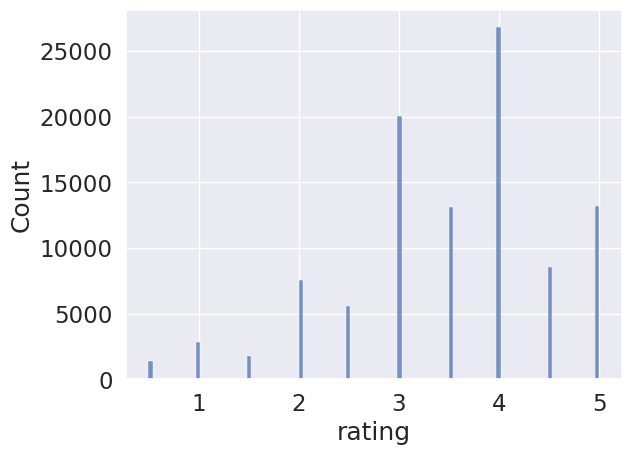

In [26]:
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.histplot(ratings['rating'].fillna(ratings['rating'].median()))

In [27]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [28]:
# Create a user-item matrix
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Convert the user-item matrix into a numpy array
user_item_matrix_array = user_item_matrix.values
user_item_matrix_array

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [30]:
# Calculate the similarity matrix (cosine similarity)
similarity_matrix = np.dot(user_item_matrix_array, user_item_matrix_array.T)
similarity_matrix.shape

(610, 610)

In [31]:
# Make recommendations for a specific user
user_id = 1

# Get the user's ratings
user_ratings = user_item_matrix.loc[user_id]

# Calculate the weighted average of similar users' ratings
weighted_sum = np.dot(similarity_matrix[user_id-1], user_item_matrix_array)
weighted_sum /= np.sum(np.abs(similarity_matrix[user_id-1]))
weighted_sum

# Find unrated movies and their predicted ratings
unrated_movies = np.where(user_ratings == 0)[0]
predicted_ratings = weighted_sum[unrated_movies]

# Sort the recommendations by predicted rating
sorted_indices = np.argsort(predicted_ratings)[::-1]
sorted_movies = unrated_movies[sorted_indices]
sorted_ratings = predicted_ratings[sorted_indices]

print(unrated_movies)
print(predicted_ratings)
print(sorted_indices)
print(sorted_movies)
print(sorted_ratings)

# Display top 10 movie recommendations
top_10_recommendations = sorted(zip(sorted_movies, sorted_ratings), key=lambda x: x[1], reverse=True)[:10]
top_10_recommendations
for movie, rating in top_10_recommendations:
    movie_id = movie + 1
    movie_title = movies.loc[movie_id-1, 'title'] if movie_id <= len(movies) else None
    if movie_title:
        print(f"Movie: {movie_title}, Predicted Rating: {rating}")
    else:
        print(f"No matching movie found for ID: {movie_id}")

[   1    3    4 ... 9721 9722 9723]
[1.19503784e+00 3.05070247e-02 3.57588926e-01 ... 2.26333799e-04
 2.26333799e-04 2.94880607e-03]
[ 259  475  615 ... 8754 6391 8929]
[ 277  507  659 ... 8986 6623 9161]
[2.93878179 2.51155226 2.44420456 ... 0.         0.         0.        ]
Movie: Shawshank Redemption, The (1994), Predicted Rating: 2.9387817883511076
Movie: Terminator 2: Judgment Day (1991), Predicted Rating: 2.511552261859891
Movie: Godfather, The (1972), Predicted Rating: 2.444204561411288
Movie: Iron Giant, The (1999), Predicted Rating: 2.237617231669734
Movie: White Water Summer (1987), Predicted Rating: 2.1552843861088324
Movie: Twelve Monkeys (a.k.a. 12 Monkeys) (1995), Predicted Rating: 2.0506535042014944
Movie: Die Hard (1988), Predicted Rating: 2.000907182818586
Movie: Longest Yard, The (1974), Predicted Rating: 1.9716038844422765
Movie: Cooler, The (2003), Predicted Rating: 1.9697895188051053
Movie: Maid in Manhattan (2002), Predicted Rating: 1.9576016746853497


In [34]:
ratings_data = pd.merge(ratings,movies,on = 'movieId')
ratings_data = ratings_data.drop(['timestamp','genres'], axis=1)
ratings_data

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)
...,...,...,...,...
100831,610,160341,2.5,Bloodmoon (1997)
100832,610,160527,4.5,Sympathy for the Underdog (1971)
100833,610,160836,3.0,Hazard (2005)
100834,610,163937,3.5,Blair Witch (2016)


In [35]:
ratings_data[ratings_data['userId'] == 1].sort_values('rating',ascending=False).head(20)

,userId,movieId,rating,title
16250,1,5060,5.0,M*A*S*H (a.k.a. MASH) (1970)
14053,1,2872,5.0,Excalibur (1981)
9066,1,1291,5.0,Indiana Jones and the Last Crusade (1989)
9206,1,1298,5.0,Pink Floyd: The Wall (1982)
14254,1,2948,5.0,From Russia with Love (1963)
14201,1,2947,5.0,Goldfinger (1964)
14169,1,2944,5.0,"Dirty Dozen, The (1967)"
14078,1,2899,5.0,Gulliver's Travels (1939)
13849,1,2858,5.0,American Beauty (1999)
13497,1,2700,5.0,"South Park: Bigger, Longer and Uncut (1999)"


In [36]:
user_films = ratings_data.groupby('userId').agg(lambda x: x.tolist())
user_films

,movieId,rating,title
userId,,,
1,"[1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163,...","[4.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 5.0, ...","[Toy Story (1995), Grumpier Old Men (1995), He..."
2,"[333, 3578, 318, 1704, 6874, 8798, 46970, 4851...","[4.0, 4.0, 3.0, 4.5, 4.0, 3.5, 4.0, 4.0, 4.5, ...","[Tommy Boy (1995), Gladiator (2000), Shawshank..."
3,"[527, 1275, 1587, 2018, 2090, 2105, 3703, 31, ...","[0.5, 3.5, 4.5, 0.5, 0.5, 2.0, 5.0, 0.5, 0.5, ...","[Schindler's List (1993), Highlander (1986), C..."
4,"[47, 235, 260, 296, 441, 457, 553, 593, 608, 6...","[2.0, 2.0, 5.0, 1.0, 1.0, 5.0, 2.0, 5.0, 5.0, ...","[Seven (a.k.a. Se7en) (1995), Ed Wood (1994), ..."
5,"[1, 50, 110, 296, 316, 349, 367, 457, 527, 590...","[4.0, 4.0, 4.0, 5.0, 2.0, 3.0, 4.0, 4.0, 5.0, ...","[Toy Story (1995), Usual Suspects, The (1995),..."
...,...,...,...
606,"[1, 47, 50, 70, 110, 157, 223, 231, 235, 260, ...","[2.5, 3.0, 4.5, 4.0, 3.5, 4.0, 4.5, 2.5, 3.5, ...","[Toy Story (1995), Seven (a.k.a. Se7en) (1995)..."
607,"[1, 110, 260, 296, 316, 423, 457, 480, 527, 55...","[4.0, 5.0, 3.0, 3.0, 3.0, 3.0, 5.0, 4.0, 5.0, ...","[Toy Story (1995), Braveheart (1995), Star War..."
608,"[1, 3, 47, 50, 70, 110, 163, 216, 223, 231, 26...","[2.5, 2.0, 4.5, 4.5, 3.0, 4.0, 3.0, 2.5, 2.5, ...","[Toy Story (1995), Grumpier Old Men (1995), Se..."


## Collaboarative with Test Train Split

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [38]:
ratings_data

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)
...,...,...,...,...
100831,610,160341,2.5,Bloodmoon (1997)
100832,610,160527,4.5,Sympathy for the Underdog (1971)
100833,610,160836,3.0,Hazard (2005)
100834,610,163937,3.5,Blair Witch (2016)


In [39]:
# Split the data into train and test sets
train_data, test_data = train_test_split(ratings_data, test_size=0.2, random_state=42)

In [40]:
# Create a pivot table of the training data
train_matrix = train_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [41]:
# Create a pivot table of the test data
test_matrix = test_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [42]:
# Create a matrix of zeros with the same shape as the test matrix
predicted_matrix = np.zeros(test_matrix.shape)

In [43]:
# Iterate over each user and movie in the test matrix
for user_index, user_id in enumerate(test_matrix.index):
    for movie_index, movie_id in enumerate(test_matrix.columns):
        # If the user and movie exist in the training matrix, make a prediction
        if user_id in train_matrix.index and movie_id in train_matrix.columns:
            predicted_rating = train_matrix.loc[user_id, movie_id]
        else:
            # If the user or movie does not exist in the training matrix, use a default value (e.g., mean rating)
            predicted_rating = train_matrix.mean().mean()
        # Store the predicted rating in the predicted matrix
        predicted_matrix[user_index, movie_index] = predicted_rating


In [44]:
# Flatten the actual ratings and predicted ratings
actual_ratings = test_data['rating'].values
predicted_ratings = predicted_matrix[test_matrix != 0]

In [45]:
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))

print(f"RMSE: {rmse}")

RMSE: 3.6501865885568745


## Matrix Factoization

In [48]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [51]:
n_users = ratings['userId'].unique().shape[0]
n_movies = ratings['movieId'].unique().shape[0]
print(f'Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 610 | Number of movies = 9724


In [53]:
ratings_data = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
ratings_data.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
R = ratings_data.values
user_ratings_mean = np.mean(R, axis=1)
ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

print(user_ratings_mean[0:3])
print(ratings_demeaned.shape)
ratings_demeaned

[0.10417524 0.01177499 0.00976964]
(610, 9724)


array([[ 3.89582476, -0.10417524,  3.89582476, ..., -0.10417524,
        -0.10417524, -0.10417524],
       [-0.01177499, -0.01177499, -0.01177499, ..., -0.01177499,
        -0.01177499, -0.01177499],
       [-0.00976964, -0.00976964, -0.00976964, ..., -0.00976964,
        -0.00976964, -0.00976964],
       ...,
       [ 2.23215755,  1.73215755,  1.73215755, ..., -0.26784245,
        -0.26784245, -0.26784245],
       [ 2.98755656, -0.01244344, -0.01244344, ..., -0.01244344,
        -0.01244344, -0.01244344],
       [ 4.50611888, -0.49388112, -0.49388112, ..., -0.49388112,
        -0.49388112, -0.49388112]])

In [69]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print(f'The sparsity level of MovieLens1M dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens1M dataset is 98.3%


In [70]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

In [71]:
sigma = np.diag(sigma)

In [72]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [76]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = ratings_data.columns)
print(preds.shape)
preds.head()

(610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.167328,0.402751,0.840184,-0.076281,-0.551337,2.504091,-0.890114,-0.026443,0.196974,1.593259,...,-0.023453,-0.019967,-0.026939,-0.026939,-0.023453,-0.026939,-0.023453,-0.023453,-0.023453,-0.058732
1,0.211459,0.006658,0.033455,0.017419,0.183430,-0.062473,0.083037,0.024158,0.049330,-0.152530,...,0.019498,0.016777,0.022219,0.022219,0.019498,0.022219,0.019498,0.019498,0.019498,0.032281
2,0.003588,0.030518,0.046393,0.008176,-0.006247,0.107328,-0.012416,0.003779,0.007297,-0.059362,...,0.005909,0.006209,0.005610,0.005610,0.005909,0.005610,0.005909,0.005909,0.005909,0.008004
3,2.051549,-0.387104,-0.252199,0.087562,0.130465,0.270210,0.477835,0.040313,0.025858,-0.017365,...,0.004836,0.004172,0.005500,0.005500,0.004836,0.005500,0.004836,0.004836,0.004836,-0.023311
4,1.344738,0.778511,0.065749,0.111744,0.273144,0.584426,0.254930,0.128788,-0.085541,1.023455,...,-0.008042,-0.007419,-0.008664,-0.008664,-0.008042,-0.008664,-0.008042,-0.008042,-0.008042,-0.010127


In [83]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print(f'User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print(f'Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [84]:
already_rated, predictions = recommend_movies(preds, 1, movies, ratings, 20)

User 0 has already rated 1 movies.
Recommending highest 0 predicted ratings movies not already rated.


In [85]:
already_rated

,userId,movieId,rating,timestamp,title,genres
231,1,5060,5.0,964984002,M*A*S*H (a.k.a. MASH) (1970),"[Comedy, Drama, War]"
185,1,2872,5.0,964981680,Excalibur (1981),"[Adventure, Fantasy]"
89,1,1291,5.0,964981909,Indiana Jones and the Last Crusade (1989),"[Action, Adventure]"
90,1,1298,5.0,964984086,Pink Floyd: The Wall (1982),"[Drama, Musical]"
190,1,2948,5.0,964982191,From Russia with Love (1963),"[Action, Adventure, Thriller]"
...,...,...,...,...,...,...
170,1,2617,2.0,964982588,"Mummy, The (1999)","[Action, Adventure, Comedy, Fantasy, Horror, T..."
143,1,2253,2.0,964981775,Toys (1992),"[Comedy, Fantasy]"
148,1,2338,2.0,964983546,I Still Know What You Did Last Summer (1998),"[Horror, Mystery, Thriller]"
152,1,2389,2.0,964983094,Psycho (1998),"[Crime, Horror, Thriller]"


In [86]:
predictions

,movieId,title,genres
736,1036,Die Hard (1988),"[Action, Crime, Thriller]"
844,1221,"Godfather: Part II, The (1974)","[Crime, Drama]"
974,1387,Jaws (1975),"[Action, Horror]"
615,858,"Godfather, The (1972)","[Crime, Drama]"
1328,1968,"Breakfast Club, The (1985)","[Comedy, Drama]"
874,1259,Stand by Me (1986),"[Adventure, Drama]"
1927,2804,"Christmas Story, A (1983)","[Children, Comedy]"
1416,2080,Lady and the Tramp (1955),"[Animation, Children, Comedy, Romance]"
2765,4011,Snatch (2000),"[Comedy, Crime, Thriller]"
1417,2081,"Little Mermaid, The (1989)","[Animation, Children, Comedy, Musical, Romance]"


In [88]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=1199027 sha256=177a9b2692cab47f66d671fac53ce1dbb5332196d72eef8c1e45a7178c830ce9
  Stored in directory: /home/jovyan/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [90]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# Assuming you have the ratings DataFrame with columns: 'userId', 'movieId', 'rating'

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split the dataset for 5-fold cross-validation
cv_results = cross_validate(SVD(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the mean RMSE and MAE scores
print("Mean RMSE:", round(cv_results['test_rmse'].mean(), 4))
print("Mean MAE:", round(cv_results['test_mae'].mean(), 4))

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8713  0.8791  0.8738  0.8772  0.8710  0.8745  0.0032  
MAE (testset)     0.6664  0.6759  0.6722  0.6736  0.6711  0.6718  0.0032  
Fit time          0.55    0.63    0.55    0.55    0.63    0.58    0.04    
Test time         0.07    0.07    0.07    0.07    0.15    0.08    0.03    
Mean RMSE: 0.8745
Mean MAE: 0.6718


In [92]:
# Build the full dataset
trainset = data.build_full_trainset()

# Create an instance of the SVD algorithm
algo = SVD()

# Train the algorithm on the entire dataset
algo.fit(trainset)

In [112]:
# Make predictions for a specific user and item
user_id = 576
movie_id = 720
prediction = algo.predict(user_id, movie_id)

print(f"Predicted rating for user {user_id} and movie {movie_id}: {prediction.est}")

Predicted rating for user 576 and movie 720: 3.6766420536238185


In [105]:
ratings['userId'].value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Name: userId, Length: 610, dtype: int64

In [108]:
ratings[ratings['userId'] == 576]

,userId,movieId,rating,timestamp
89035,576,29,3.5,1358151482
89036,576,327,2.5,1358151538
89037,576,372,1.0,1358151493
89038,576,720,3.0,1358151483
89039,576,849,1.5,1358151491
89040,576,1188,1.0,1358151539
89041,576,1223,4.0,1358151540
89042,576,1231,2.0,1358151530
89043,576,1261,3.0,1358151531
89044,576,1321,4.0,1358151532


In [101]:
movies[movies['movieId'] == 43]

,movieId,title,genres
39,43,Restoration (1995),[Drama]


## Deep Learning Technique

In [7]:
# Import libraries
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
max_userid = ratings['userId'].drop_duplicates().max()
max_movieid = ratings['movieId'].drop_duplicates().max()

In [115]:
max_userid

610

In [116]:
max_movieid

193609

In [121]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [118]:
# Create training set
shuffled_ratings = ratings.sample(frac=1., random_state=42)

In [123]:
# Shuffling users
Users = shuffled_ratings['userId'].values
print(f'Users:', Users, ', shape =', Users.shape)

# Shuffling movies
Movies = shuffled_ratings['movieId'].values
print(f'Movies:', Movies, ', shape =', Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print(f'Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [432 288 599 ... 480   6 103] , shape = (100836,)
Movies: [77866   474  4351 ...  6867   981  6711] , shape = (100836,)
Ratings: [4.5 3.  3.  ... 4.  3.  5. ] , shape = (100836,)


In [126]:
# Import Keras libraries
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Embedding, Reshape, Dot
from keras.models import Model
from keras.optimizers import Adam

In [127]:
class CFModel(Model):
    def __init__(self, num_users, num_movies, embedding_size=30):
        super(CFModel, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        # Embedding layers
        self.user_embedding = Embedding(input_dim=self.num_users, output_dim=self.embedding_size, input_length=1)
        self.movie_embedding = Embedding(input_dim=self.num_movies, output_dim=self.embedding_size, input_length=1)

        # Flatten layers
        self.user_flatten = Reshape(target_shape=(self.embedding_size,))
        self.movie_flatten = Reshape(target_shape=(self.embedding_size,))

        # Dot product layer
        self.dot_product = Dot(axes=1)

    def call(self, inputs):
        user_input, movie_input = inputs

        # Embedding layers
        user_embedded = self.user_embedding(user_input)
        movie_embedded = self.movie_embedding(movie_input)

        # Flatten layers
        user_flattened = self.user_flatten(user_embedded)
        movie_flattened = self.movie_flatten(movie_embedded)

        # Dot product layer
        output = self.dot_product([user_flattened, movie_flattened])

        return output

In [129]:
# Define constants
K_FACTORS = 100 # The number of dimensional embeddings for movies and users
TEST_USER = 576 # A random test user (user_id = 2000)

In [136]:
# Define model
model = CFModel(max_userid+1, max_movieid+1, K_FACTORS)
# Compile the model using MSE as the loss function and the AdaMax learning algorithm
model.compile(loss='mse', optimizer='adamax')

In [140]:
# Callbacks monitor the validation loss
# Save the model weights each time the validation loss has improved
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)]

# Save the model weights
model.save_weights('model_weights.h5')

# Use 30 epochs, 90% training data, 10% validation data 
history = model.fit([Users, Movies], Ratings, epochs=3, validation_split=.1, verbose=2, callbacks=callbacks)

Epoch 1/3


NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

In [9]:
# Import libraries
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the maximum user ID and movie ID
max_userid = ratings['userId'].drop_duplicates().max()
max_movieid = ratings['movieId'].drop_duplicates().max()

# Create training set
shuffled_ratings = ratings.sample(frac=1., random_state=42)

# Shuffling users, movies, and ratings
Users = shuffled_ratings['userId'].values
Movies = shuffled_ratings['movieId'].values
Ratings = shuffled_ratings['rating'].values

# Import Keras libraries
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Embedding, Reshape, Dot
from keras.models import Model
from keras.optimizers import Adam

# Define Collaborative Filtering model
class CFModel(Model):
    def __init__(self, num_users, num_movies, embedding_size=30):
        super(CFModel, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        # Embedding layers
        self.user_embedding = Embedding(input_dim=self.num_users, output_dim=self.embedding_size, input_length=1)
        self.movie_embedding = Embedding(input_dim=self.num_movies, output_dim=self.embedding_size, input_length=1)

        # Flatten layers
        self.user_flatten = Reshape(target_shape=(self.embedding_size,))
        self.movie_flatten = Reshape(target_shape=(self.embedding_size,))

        # Dot product layer
        self.dot_product = Dot(axes=1)

    def call(self, inputs):
        user_input, movie_input = inputs

        # Embedding layers
        user_embedded = self.user_embedding(user_input)
        movie_embedded = self.movie_embedding(movie_input)

        # Flatten layers
        user_flattened = self.user_flatten(user_embedded)
        movie_flattened = self.movie_flatten(movie_embedded)

        # Dot product layer
        output = self.dot_product([user_flattened, movie_flattened])

        return output

# Define constants
K_FACTORS = 100
TEST_USER = 576

# Create an instance of CFModel
model = CFModel(max_userid+1, max_movieid+1, K_FACTORS)

# Compile the model using MSE as the loss function and the Adam optimizer
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# Define callbacks to monitor the validation loss and save the best model weights
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2),
    ModelCheckpoint('model_saved', monitor='val_loss', save_best_only=True, save_format='tf')
]

# Use 10 epochs, 90% training data, 10% validation data
history = model.fit([Users, Movies], Ratings, epochs=10, validation_split=0.1, verbose=2, callbacks=callbacks)

2023-07-10 04:37:45.908498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 04:37:45.986227: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Epoch 1/10


2023-07-10 04:37:47.211407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: model_saved/assets
2836/2836 - 129s - loss: 7.0037 - val_loss: 2.0486 - 129s/epoch - 46ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: model_saved/assets
2836/2836 - 129s - loss: 1.3117 - val_loss: 1.4171 - 129s/epoch - 45ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: model_saved/assets
2836/2836 - 129s - loss: 0.8608 - val_loss: 1.3151 - 129s/epoch - 45ms/step
Epoch 4/10
INFO:tensorflow:Assets written to: model_saved/assets
2836/2836 - 128s - loss: 0.6357 - val_loss: 1.2763 - 128s/epoch - 45ms/step
Epoch 5/10
INFO:tensorflow:Assets written to: model_saved/assets
2836/2836 - 130s - loss: 0.4776 - val_loss: 1.2726 - 130s/epoch - 46ms/step
Epoch 6/10
2836/2836 - 128s - loss: 0.3586 - val_loss: 1.2851 - 128s/epoch - 45ms/step
Epoch 7/10
2836/2836 - 128s - loss: 0.2667 - val_loss: 1.2983 - 128s/epoch - 45ms/step


In [11]:
# Show the best validation RMSE
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print(f'Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 5 = 1.1281


In [14]:
# Use the pre-trained model
trained_model = CFModel(max_userid, max_movieid, K_FACTORS)
# # Load weights
# trained_model.load_weights('model_weights.h5')

In [15]:
# Function to predict the ratings given User ID and Movie ID
def predict_rating(user_id, movie_id):
    return trained_model.rate(user_id - 1, movie_id - 1)

In [17]:
user_ratings = ratings[ratings['userId'] == TEST_USER][['userId', 'movieId', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TEST_USER, x['movieId']), axis=1)
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_id', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(20)

AttributeError: 'CFModel' object has no attribute 'rate'

## Attempt 2: Collaborative Bert with user ratings sytem

In [6]:
# Filter out movies with insufficient ratings
min_ratings_threshold = 10
movie_counts = ratings['movieId'].value_counts()
valid_movies = movie_counts[movie_counts >= min_ratings_threshold].index
df_ratings = ratings[ratings['movieId'].isin(valid_movies)]
df_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100818,610,159093,3.0,1493847704
100829,610,164179,5.0,1493845631
100830,610,166528,4.0,1493879365
100833,610,168250,5.0,1494273047


In [7]:
# Filter out users with a low number of ratings
min_ratings_per_user = 5
user_counts = df_ratings['userId'].value_counts()
valid_users = user_counts[user_counts >= min_ratings_per_user].index
df_ratings = df_ratings[df_ratings['userId'].isin(valid_users)]
df_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100818,610,159093,3.0,1493847704
100829,610,164179,5.0,1493845631
100830,610,166528,4.0,1493879365
100833,610,168250,5.0,1494273047


In [29]:
# Filter out a subset of users
num_users = 3  # Specify the desired number of users
user_counts = df_ratings['userId'].value_counts()
selected_users = user_counts.sample(n=num_users, random_state=42).index
df_ratings = df_ratings[df_ratings['userId'].isin(selected_users)]
df_ratings

,userId,movieId,rating,timestamp
30180,211,50,4.0,1350912267
30181,211,260,4.5,1350913284
30182,211,296,4.5,1350913106
30183,211,318,5.0,1350913048
30184,211,356,4.5,1350912824
...,...,...,...,...
84242,538,68954,5.0,1307846882
84243,538,69757,4.5,1307846087
84244,538,69844,4.0,1307847399
84245,538,80549,4.5,1307846747


In [30]:
# Step 2: Encode user ratings using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [31]:
# Tokenize and encode movie titles
encoded_movies = tokenizer.batch_encode_plus(
    movies['title'].values.tolist(),
    add_special_tokens=True,
    padding='longest',
    return_tensors='tf',
    truncation=True
)

In [32]:
# Tokenize and encode user-rated movie titles
encoded_ratings = tokenizer.batch_encode_plus(
    df_ratings['movieId'].map(movies.set_index('movieId')['title']).values.tolist(),
    add_special_tokens=True,
    padding='longest',
    return_tensors='tf',
    truncation=True
)

In [33]:
# Step 3: Build user representations using BERT transformer
input_ids_movies = encoded_movies['input_ids']
attention_masks_movies = encoded_movies['attention_mask']
input_ids_ratings = encoded_ratings['input_ids']
attention_masks_ratings = encoded_ratings['attention_mask']

In [34]:
# Load the BERT transformer model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [38]:
# # Obtain movie representations from BERT
# movie_representations = bert_model(input_ids_movies, attention_mask=attention_masks_movies)[0]

In [ ]:
# Obtain user representations from BERT
user_representations = bert_model(input_ids_ratings, attention_mask=attention_masks_ratings)[0]


In [ ]:
# Aggregate user representations to create fixed-size user representations
user_representations = tf.reduce_mean(user_representations, axis=1)


In [ ]:
# Step 4: Compute user similarity
user_similarity = cosine_similarity(user_representations)


In [ ]:
# Step 5: Generate movie recommendations
def get_top_n_movies(user_id, n=5):
    user_ratings = df_ratings[df_ratings['userId'] == user_id]
    user_representation = user_representations[user_id]
    user_similarity_scores = user_similarity[user_id]
    
    # Filter out movies the user has already rated
    rated_movie_ids = user_ratings['movieId'].values
    unrated_movie_ids = np.setdiff1d(valid_movies, rated_movie_ids)
    
    # Calculate movie scores based on user similarity
    movie_scores = np.dot(user_similarity_scores, movie_representations[unrated_movie_ids].numpy().T)
    
    # Sort movies by scores
    top_n_indices = np.argsort(movie_scores)[-n:][::-1]
    top_n_movies = df_movies[df_movies['movieId'].isin(unrated_movie_ids[top_n_indices])]
    
    return top_n_movies


In [ ]:
# Example: Generate movie recommendations for a randomly selected user
user_id = selected_users[0]
recommendations = get_top_n_movies(user_id)

In [ ]:
print(f"Movie recommendations for User {user_id}:")
print(recommendations[['movieId', 'title']])

## Attempt 1: Welcome to Anxiety Town

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import BertTokenizer, TFBertModel

2023-07-07 16:50:22.719310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 16:50:22.975790: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [78]:
tags_agg = tags.groupby('movieId')['tag'].agg(list)
tags_agg

movieId
1                                       [pixar, pixar, fun]
2         [fantasy, magic board game, Robin Williams, game]
3                                              [moldy, old]
5                                       [pregnancy, remake]
7                                                  [remake]
                                ...                        
183611                      [Comedy, funny, Rachel McAdams]
184471    [adventure, Alicia Vikander, video game adapta...
187593                [Josh Brolin, Ryan Reynolds, sarcasm]
187595                           [Emilia Clarke, star wars]
193565                   [anime, comedy, gintama, remaster]
Name: tag, Length: 1572, dtype: object

In [80]:
avg_ratings = ratings.groupby('movieId')['rating'].mean()
avg_ratings

movieId
1         3.920930
2         3.431818
3         3.259615
4         2.357143
5         3.071429
            ...   
193581    4.000000
193583    3.500000
193585    3.500000
193587    3.500000
193609    4.000000
Name: rating, Length: 9724, dtype: float64

In [81]:
# Merge the two datasets
data = pd.merge(movies,avg_ratings, on='movieId')
data = pd.merge(data, tags_agg, on='movieId', how='inner')
data

,movieId,title,genres,rating,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.920930,"[pixar, pixar, fun]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.431818,"[fantasy, magic board game, Robin Williams, game]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.259615,"[moldy, old]"
3,5,Father of the Bride Part II (1995),[Comedy],3.071429,"[pregnancy, remake]"
4,7,Sabrina (1995),"[Comedy, Romance]",3.185185,[remake]
...,...,...,...,...,...
1549,183611,Game Night (2018),"[Action, Comedy, Crime, Horror]",4.000000,"[Comedy, funny, Rachel McAdams]"
1550,184471,Tomb Raider (2018),"[Action, Adventure, Fantasy]",2.500000,"[adventure, Alicia Vikander, video game adapta..."
1551,187593,Deadpool 2 (2018),"[Action, Comedy, Sci-Fi]",3.875000,"[Josh Brolin, Ryan Reynolds, sarcasm]"
1552,187595,Solo: A Star Wars Story (2018),"[Action, Adventure, Children, Sci-Fi]",3.900000,"[Emilia Clarke, star wars]"


In [110]:
df = data.loc[0:1553].copy()
df

,movieId,title,genres,rating,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.920930,"[pixar, pixar, fun]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.431818,"[fantasy, magic board game, Robin Williams, game]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.259615,"[moldy, old]"
3,5,Father of the Bride Part II (1995),[Comedy],3.071429,"[pregnancy, remake]"
4,7,Sabrina (1995),"[Comedy, Romance]",3.185185,[remake]
...,...,...,...,...,...
1549,183611,Game Night (2018),"[Action, Comedy, Crime, Horror]",4.000000,"[Comedy, funny, Rachel McAdams]"
1550,184471,Tomb Raider (2018),"[Action, Adventure, Fantasy]",2.500000,"[adventure, Alicia Vikander, video game adapta..."
1551,187593,Deadpool 2 (2018),"[Action, Comedy, Sci-Fi]",3.875000,"[Josh Brolin, Ryan Reynolds, sarcasm]"
1552,187595,Solo: A Star Wars Story (2018),"[Action, Adventure, Children, Sci-Fi]",3.900000,"[Emilia Clarke, star wars]"


In [111]:
# Normalize the average user rating
scaler = MinMaxScaler()
df['rating_normalized'] = scaler.fit_transform(df[['rating']])
df

,movieId,title,genres,rating,tag,rating_normalized
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.920930,"[pixar, pixar, fun]",0.760207
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.431818,"[fantasy, magic board game, Robin Williams, game]",0.651515
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.259615,"[moldy, old]",0.613248
3,5,Father of the Bride Part II (1995),[Comedy],3.071429,"[pregnancy, remake]",0.571429
4,7,Sabrina (1995),"[Comedy, Romance]",3.185185,[remake],0.596708
...,...,...,...,...,...,...
1549,183611,Game Night (2018),"[Action, Comedy, Crime, Horror]",4.000000,"[Comedy, funny, Rachel McAdams]",0.777778
1550,184471,Tomb Raider (2018),"[Action, Adventure, Fantasy]",2.500000,"[adventure, Alicia Vikander, video game adapta...",0.444444
1551,187593,Deadpool 2 (2018),"[Action, Comedy, Sci-Fi]",3.875000,"[Josh Brolin, Ryan Reynolds, sarcasm]",0.750000
1552,187595,Solo: A Star Wars Story (2018),"[Action, Adventure, Children, Sci-Fi]",3.900000,"[Emilia Clarke, star wars]",0.755556


In [112]:
# Create feature representations
X = df[['genres', 'rating_normalized','tag']].values
y = df['title'].values

In [113]:
# Encode the labels using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [114]:
X

array([[list(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']),
        0.7602067183462533, list(['pixar', 'pixar', 'fun'])],
       [list(['Adventure', 'Children', 'Fantasy']), 0.6515151515151514,
        list(['fantasy', 'magic board game', 'Robin Williams', 'game'])],
       [list(['Comedy', 'Romance']), 0.6132478632478633,
        list(['moldy', 'old'])],
       ...,
       [list(['Action', 'Comedy', 'Sci-Fi']), 0.75,
        list(['Josh Brolin', 'Ryan Reynolds', 'sarcasm'])],
       [list(['Action', 'Adventure', 'Children', 'Sci-Fi']),
        0.7555555555555555, list(['Emilia Clarke', 'star wars'])],
       [list(['Action', 'Animation', 'Comedy', 'Sci-Fi']),
        0.6666666666666665,
        list(['anime', 'comedy', 'gintama', 'remaster'])]], dtype=object)

In [115]:
# Split the data into training and testing sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [117]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [118]:
# Tokenize and encode the input sequences
def tokenize_sequences(texts):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'][0])
        attention_masks.append(encoded['attention_mask'][0])

    return np.array(input_ids), np.array(attention_masks)

In [119]:
# Tokenize and encode the genre type
input_genres_train, input_masks_train = tokenize_sequences(X_train[:, 0])
input_genres_test, input_masks_test = tokenize_sequences(X_test[:, 0])

In [120]:
input_genres_train

array([[101, 100, 100, ...,   0,   0,   0],
       [101, 100, 100, ...,   0,   0,   0],
       [101, 100, 102, ...,   0,   0,   0],
       ...,
       [101, 100, 100, ...,   0,   0,   0],
       [101, 100, 100, ...,   0,   0,   0],
       [101, 100, 100, ...,   0,   0,   0]], dtype=int32)

In [121]:
# Normalize the average user rating
input_ratings_train = X_train[:, 1].astype(float).reshape(-1, 1)
input_ratings_test = X_test[:, 1].astype(float).reshape(-1, 1)

In [122]:
# Define the input and output dimensions
input_ids = layers.Input(shape=(128,), dtype=tf.int32)
attention_mask = layers.Input(shape=(128,), dtype=tf.int32)
input_ratings = layers.Input(shape=(1,), dtype=tf.float32)

In [123]:
# Build the BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]
pooler_output = layers.GlobalAveragePooling1D()(bert_output)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [124]:
# Concatenate the BERT output and input ratings
concatenated = layers.Concatenate()([pooler_output, input_ratings])

# Adjust the output layer to match the number of classes
output_layer = layers.Dense(len(label_encoder.classes_), activation='softmax')(concatenated)

model = keras.Model(inputs=[input_ids, attention_mask, input_ratings], outputs=output_layer)
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer='adam')



In [125]:
# Convert the encoded labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

In [126]:
# Train the model
model.fit(
    [input_genres_train, input_masks_train, input_ratings_train],
    y_train_one_hot,
    batch_size=32,
    epochs=10,
    validation_data=([input_genres_test, input_masks_test, input_ratings_test], y_test_one_hot)
)

Epoch 1/10
39/39 [==============================] - 245s 6s/step - loss: 7.4550 - val_loss: 7.3017
Epoch 2/10
39/39 [==============================] - 245s 6s/step - loss: 7.5324 - val_loss: 8.6873
Epoch 3/10
39/39 [==============================] - 526s 14s/step - loss: 7.3165 - val_loss: 9.3577
Epoch 4/10
39/39 [==============================] - 245s 6s/step - loss: 7.3042 - val_loss: 9.4344
Epoch 5/10
39/39 [==============================] - 237s 6s/step - loss: 7.2746 - val_loss: 9.8058
Epoch 6/10
39/39 [==============================] - 238s 6s/step - loss: 7.2436 - val_loss: 10.0896
Epoch 7/10
39/39 [==============================] - 235s 6s/step - loss: 7.2356 - val_loss: 10.2208
Epoch 8/10
39/39 [==============================] - 232s 6s/step - loss: 7.2190 - val_loss: 10.2715
Epoch 9/10
39/39 [==============================] - 238s 6s/step - loss: 7.2112 - val_loss: 10.3713
Epoch 10/10
39/39 [==============================] - 233s 6s/step - loss: 7.2049 - val_loss: 10.4885


In [127]:
df.head()

,movieId,title,genres,rating,tag,rating_normalized
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.920930,"[pixar, pixar, fun]",0.760207
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.431818,"[fantasy, magic board game, Robin Williams, game]",0.651515
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.259615,"[moldy, old]",0.613248
3,5,Father of the Bride Part II (1995),[Comedy],3.071429,"[pregnancy, remake]",0.571429
4,7,Sabrina (1995),"[Comedy, Romance]",3.185185,[remake],0.596708


In [128]:
# Step 5: Make recommendations
def preprocess_input(movie_name):
    # Preprocess the input movie name
    input_genre = df.loc[df['title'] == movie_name, 'genres'].values[0]
    input_rating = df.loc[df['title'] == movie_name, 'rating_normalized'].values[0]
    
    # Tokenize and encode the input sequences
    input_genre_encoded, input_mask = tokenize_sequences([input_genre])
    
    return input_genre_encoded, input_mask, np.array([[input_rating]])

In [129]:
def recommend_movies(movie_name):
    # Preprocess the input movie name
    input_genre_encoded, input_mask, input_rating = preprocess_input(movie_name)

    # Get the model predictions
    predictions = model.predict([input_genre_encoded, input_mask, input_rating])

    # Get the top 5 movie recommendations
    top_indices = np.argsort(predictions[0])[::-1][:5]
    recommended_movies = df.loc[top_indices, 'title'].values

    return recommended_movies

In [130]:
input_movie = 'Toy Story (1995)'
recommendations = recommend_movies(input_movie)
print(f"Recommended movies for '{input_movie}':")
for movie in recommendations:
    print(movie)

1/1 [==============================] - 5s 5s/step
Recommended movies for 'Toy Story (1995)':
Keeping the Faith (2000)
Spanglish (2004)
Haunted World of El Superbeasto, The (2009)
Grand Illusion (La grande illusion) (1937)
America's Sweethearts (2001)


In [132]:
input_movie = 'Jumanji (1995)'
recommendations = recommend_movies(input_movie)
print(f"Recommended movies for '{input_movie}':")
for movie in recommendations:
    print(movie)

1/1 [==============================] - 0s 203ms/step
Recommended movies for 'Jumanji (1995)':
Keeping the Faith (2000)
Spanglish (2004)
Haunted World of El Superbeasto, The (2009)
Grand Illusion (La grande illusion) (1937)
America's Sweethearts (2001)


In [133]:
df.tail()

,movieId,title,genres,rating,tag,rating_normalized
1549,183611,Game Night (2018),"[Action, Comedy, Crime, Horror]",4.000,"[Comedy, funny, Rachel McAdams]",0.777778
1550,184471,Tomb Raider (2018),"[Action, Adventure, Fantasy]",2.500,"[adventure, Alicia Vikander, video game adapta...",0.444444
1551,187593,Deadpool 2 (2018),"[Action, Comedy, Sci-Fi]",3.875,"[Josh Brolin, Ryan Reynolds, sarcasm]",0.750000
1552,187595,Solo: A Star Wars Story (2018),"[Action, Adventure, Children, Sci-Fi]",3.900,"[Emilia Clarke, star wars]",0.755556
1553,193565,Gintama: The Movie (2010),"[Action, Animation, Comedy, Sci-Fi]",3.500,"[anime, comedy, gintama, remaster]",0.666667


In [134]:
input_movie = 'Solo: A Star Wars Story (2018)'
recommendations = recommend_movies(input_movie)
print(f"Recommended movies for '{input_movie}':")
for movie in recommendations:
    print(movie)

1/1 [==============================] - 0s 208ms/step
Recommended movies for 'Solo: A Star Wars Story (2018)':
Keeping the Faith (2000)
Spanglish (2004)
Haunted World of El Superbeasto, The (2009)
Grand Illusion (La grande illusion) (1937)
America's Sweethearts (2001)


In [116]:
# Evaluate accuracy on training data
train_predictions = model.predict([input_genres_train, input_masks_train, input_ratings_train])
train_accuracy = np.mean(np.argmax(train_predictions, axis=1) == y_train_encoded)

# Evaluate accuracy on testing data
test_predictions = model.predict([input_genres_test, input_masks_test, input_ratings_test])
test_accuracy = np.mean(np.argmax(test_predictions, axis=1) == y_test_encoded)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

6/6 [==============================] - 8s 1s/step


/tmp/ipykernel_1520/761606495.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  train_accuracy = np.mean(np.argmax(train_predictions, axis=1) == y_train_encoded)


2/2 [==============================] - 2s 575ms/step
Training Accuracy: 0.0000
Testing Accuracy: 0.0000


/tmp/ipykernel_1520/761606495.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  test_accuracy = np.mean(np.argmax(test_predictions, axis=1) == y_test_encoded)


## Data Exploring

In [ ]:
# merge the data frames on the 'movieId' column
merged_tags_df = pd.merge(movies_df, tags_df, on='movieId', how='inner')
merged_tags_top = merged_df[merged_df['title'].isin(top_movies)]
merged_tags_top.groupby(['tag']).count().sort_values(['movieId'],ascending=False)

,movieId,title,genres,userId,timestamp
tag,,,,,
thought-provoking,10,10,10,10,10
twist ending,10,10,10,10,10
sci-fi,9,9,9,9,9
superhero,8,8,8,8,8
time travel,7,7,7,7,7
...,...,...,...,...,...
characters,1,1,1,1,1
character development,1,1,1,1,1
challenging,1,1,1,1,1


In [ ]:
merged_tags_top[(merged_tags_top['tag'] == 'thought-provoking') | 
                (merged_tags_top['tag'] == 'twist ending') |
                (merged_tags_top['tag'] == 'sci-fi') |
                (merged_tags_top['tag'] == 'time travel')]

,movieId,title,genres,userId,tag,timestamp
27,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,424,time travel,1457901872
28,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,474,time travel,1137206826
35,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,477,time travel,1242494304
36,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,477,twist ending,1242494302
57,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,424,twist ending,1457842458
63,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,424,twist ending,1457842306
138,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,76,sci-fi,1439165588
150,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,205,sci-fi,1519899078
155,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,424,sci-fi,1457900766
384,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,599,thought-provoking,1498456638


In [ ]:
# merge the data frames on the 'movieId' column
merged_df = pd.merge(movies_df, rating_df, on='movieId', how='inner')
print(merged_df.shape)

#count the amount of times movies have been rated.
movie_counts = merged_df.groupby(['title']).count().sort_values(['rating'],ascending=False)

# select the top 100 most counted movies
top_movies = movie_counts.head(100).index.tolist()

(100836, 6)


In [47]:
# filter merged_df to show only top movies
merged_df_top = merged_df[merged_df['title'].isin(top_movies)]
merged_df_top = merged_df_top.groupby(['title']).mean().sort_values(['rating'],ascending=False)
merged_df_top.head(50)

,movieId,userId,rating,timestamp
title,,,,
"Shawshank Redemption, The (1994)",318.0,302.299685,4.429022,1.189037e+09
"Godfather, The (1972)",858.0,297.744792,4.289062,1.215667e+09
Fight Club (1999),2959.0,319.894495,4.272936,1.294796e+09
"Godfather: Part II, The (1974)",1221.0,307.581395,4.259690,1.207514e+09
Goodfellas (1990),1213.0,302.357143,4.250000,1.211697e+09
"Dark Knight, The (2008)",58559.0,305.013423,4.238255,1.397625e+09
"Usual Suspects, The (1995)",50.0,299.279412,4.237745,1.162501e+09
"Princess Bride, The (1987)",1197.0,308.246479,4.232394,1.185277e+09
Star Wars: Episode IV - A New Hope (1977),260.0,304.717131,4.231076,1.189281e+09
